## Objective
Test model's performance on extracted samples of real spikes from a raw recording

In [2]:
%load_ext autoreload
%autoreload

# Update PATH to allow imports
import sys
sys.path.append("/data/MEAprojects/DLSpikeSorter")

# Imports
from src.model import ModelSpikeSorter
from src.data import Recording
from src.utils import torch_to_np, random_seed
from src.plot import set_ticks, set_dpi
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from pandas import DataFrame

In [20]:
class RecordingSampler(Dataset):
    """
    Class to get extracted samples from raw recording
    """

    def __init__(self, rec_path: Path, sorted_npz_path: Path,
                 num_output_locs: int, front_buffer: int, sample_size: int,
                 thresh_amp: float, thresh_std: float,
                 device="cuda", dtype=torch.float32,
                 length=10000, max_wf_count=10):
        """
        :param rec_path:
            to data.raw.npy
        :param sorted_npz_path:
            from spikesort_matlab4.py to sorted.npz
        :param num_output_locs:
            model.num_output_locs
        :param front_buffer:
            model.buffer_front_sample
        :param sample_size:
            model.sample_size
        :param thresh_amp:
        :param thresh_std:
        :param device:
        :param dtype:
        :param max_wf_count
            Max number of wf that will probably appear in samples of recording
        """
        sorted_npz = np.load(sorted_npz_path, allow_pickle=True)
        self.rec = Recording(rec_path=rec_path, sample_size=sample_size, start=0, spike_times=sorted_npz["spike_times"])
        self.rec_duration = self.rec.traces.shape[1]  # Number of samples in recording

        self.num_output_locs = num_output_locs
        self.front_buffer = front_buffer
        self.sample_size = sample_size

        self.device = device
        self.dtype = dtype

        self.max_wf_count = max_wf_count
        self.length = length

        chan_to_st = {}
        for unit in sorted_npz["units"]:
            # template = unit["template"].T  # (n_channels, n_samples)
            if thresh_amp is not None:
                channels = (unit["amplitudes"] >= thresh_amp) * (unit["std_norms"] <= thresh_std)
            else:
                channels = [0] * len(unit["amplitudes"])
                channels[np.argmax(unit["amplitudes"])] = 1

            for c, curated in enumerate(channels):
                if not curated: continue

                if c not in chan_to_st:
                    chan_to_st[c] = unit["spike_train"].tolist()
                else:
                    chan_to_st[c].extend(unit["spike_train"])

            # for channel in range(template.shape[0]):
            #     if unit["amplitudes"][channel] >= thresh_amp and unit["std_norms"][channel] <= thresh_std:
            #         if channel not in chan_to_st:
            #             chan_to_st[channel] = unit["spike_train"].tolist()
            #         else:
            #             chan_to_st[channel].extend(unit["spike_train"])
        self.channel_spikes = {c: sorted(st) for c, st in chan_to_st.items()}  # Dictionary of {channel_idx: [spike_time1, spike_time2, spike_time3, ... ]}
        self.channels = list(self.channel_spikes.keys())  # List of all channels with spikes

    def __len__(self):
        return self.length

    def __getitem__(self, item):
        return self.get_sample()

    def get_sample(self, has_wf=None):
        # Get a sample from a recording

        has_wf = np.random.randint(2) if has_wf is None else has_wf
        trace, wf_locs, alphas = self.get_wf_sample() if has_wf else self.get_noise_sample()
        num_wfs = len(wf_locs)

        # Format data for model
        count_diff = (self.max_wf_count - len(wf_locs))

        wf_locs += count_diff * [-1]
        alphas += count_diff * [np.inf]

        trace = torch.tensor(trace - np.mean(trace), dtype=self.dtype, device=self.device)[None, :]
        num_wfs = torch.tensor(num_wfs, dtype=torch.int, device=self.device)
        wf_locs = torch.tensor(wf_locs, dtype=torch.int, device=self.device)
        alphas = torch.tensor(alphas, dtype=self.dtype, device=self.device)

        return trace, num_wfs, wf_locs, alphas

    def get_wf_sample(self):
        """
        Get a sample with at least 1 wf

        1. Get a random channel with spikes
        2. Get a random spike time (st)
        3. Get random location for st in [0, self.num_output_locs) (loc)
        4. Get all spikes in
            start = st - loc - self.front_buffer
            [start, start + self.sample_size)

        :return:
            trace: torch.Tensor: (1, self.sample_size)
            wf_locs: torch.Tensor: (n_locs,)
            wf_alphas: torch.Tensor: (n_locs,)
        """

        # Extract sample from reccording

        count = None
        while count is None:

            chan = np.random.choice(self.channels)
            spikes = self.channel_spikes[chan]
            st = np.random.choice(spikes)
            loc = np.random.randint(self.num_output_locs)

            start = st - loc - self.front_buffer
            # Prevent samples from going outside bounds of recording
            if start < 0:
                start = 0
            elif start + self.sample_size > self.rec_duration:
                start = self.rec_duration - self.sample_size

            i_start = np.searchsorted(spikes, start, side='left')
            i_stop = np.searchsorted(spikes, start + self.sample_size, side='right')

            # Test method
            # print()
            # print(loc, self.loc_size)
            # print([spikes[i] for i in range(start, stop)])
            # print([x - spike_time for x in spikes[spikes.index(spike_time) - 1: spikes.index(spike_time) + 2]])
            # np.unique since sometimes spikes occur at same frame

            trace = self.rec[chan, start: start+self.sample_size]
            wf_locs = np.unique([spikes[i] - start for i in range(i_start, i_stop)])  # need unique since sometimes multiple spikes on same frame
            wf_locs = [l for l in wf_locs if self.front_buffer <= l < self.front_buffer + self.num_output_locs]
            alphas = [5] * len(wf_locs)  # 5 serves no purpose other than not being equal to np.inf

            if len(wf_locs) >= 2: count = "sdf"
        print(st, chan, wf_locs)
        return trace, wf_locs, alphas

    def get_noise_sample(self):
        # empty [] for there being no wf_locs and no alphas (same return format as self.get_wf_sample)

        return self.rec.get_sample(), [], []

    def plot_sample(self, trace, num_wfs, wf_locs, alphas, ax=None):
        """

        :param trace:
        :param num_wfs:
        :param wf_locs:
        :param alphas:
        :param ax:
            Axis to plot on
            If None, create new axis and end with plt.show()
        """
        trace = torch_to_np(trace).flatten()
        num_wfs = torch_to_np(num_wfs)
        wf_locs = torch_to_np(wf_locs)

        if ax is None:
            fig, ax = plt.subplots(1)

        set_ticks((ax,), trace)

        ax.plot(trace)
        for i, loc in enumerate(wf_locs):
            if loc == -1: break
            ax.axvline(loc, color="blue", linestyle="dashed", label="Spike" if i == 0 else None)

        if num_wfs > 0:
            plt.legend()

        if ax is None:
            plt.show()

In [9]:
# Load model
MODEL_PATH = "/data/MEAprojects/DLSpikeSorter/models/v0_4_4/2954"
##
model = ModelSpikeSorter.load(MODEL_PATH)

In [21]:
# Recording
DATA_ROOT = "/data/MEAprojects/DLSpikeSorter"
REC = "2954"
##
rec = Path(DATA_ROOT) / REC
rec_sampler = RecordingSampler(rec_path=rec / "data.raw.npy", sorted_npz_path=rec / "sorted.npz",
                               num_output_locs=model.num_output_locs, front_buffer=model.buffer_front_sample, sample_size=model.sample_size,
                               thresh_amp=None, thresh_std=0.6)

In [141]:
# Get model's performance
random_seed(231)
dataloader = DataLoader(rec_sampler, batch_size=2000)
# model.tune_loc_prob_thresh(dataloader)
perf = model.perf(dataloader, plot_preds=("aall",), max_plots=10)
_ = model.perf_report(REC, perf)

Using random seed 231
5118: Loss: 5.887 | WF Detected: 130.1% | Accuracy: 99.9% | Recall: 98.4% | Precision: 75.6% | F1 Score: 85.5% | Loc MAD: 0.75 frames = 0.0376 ms


Using random seed 2
1833686 96 [70, 141]
1992783 334 [40, 119]
2810807 214 [58, 114]
969092 214 [75, 154]
2400631 985 [100, 150]
3159952 334 [64, 138]
2989469 985 [141, 142]
1438496 334 [43, 118]
2688473 96 [76, 125]
739321 214 [48, 117]
2400376 154 [54, 154]
2747480 214 [86, 145]
2391057 214 [52, 112]
3143952 550 [42, 154]
541004 334 [52, 130]
1309903 96 [62, 116]
476956 214 [61, 150]
1686029 985 [125, 126]
2558898 550 [61, 125]
1274776 6 [56, 158]
563130 214 [57, 158]
1947379 214 [73, 146]
1135976 76 [40, 151]
3281070 214 [54, 128]
3564118 985 [141, 142]


/tmp/ipykernel_1513534/3900296130.py:169: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)


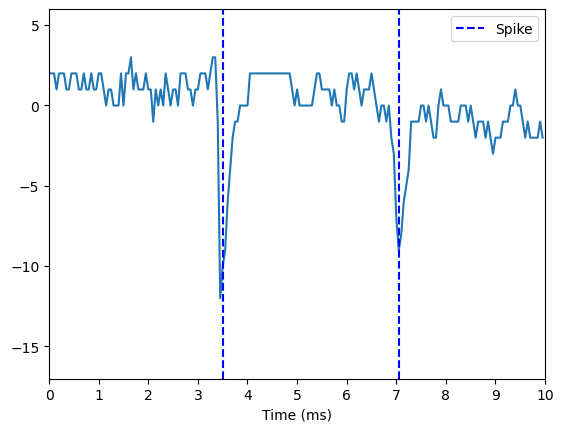

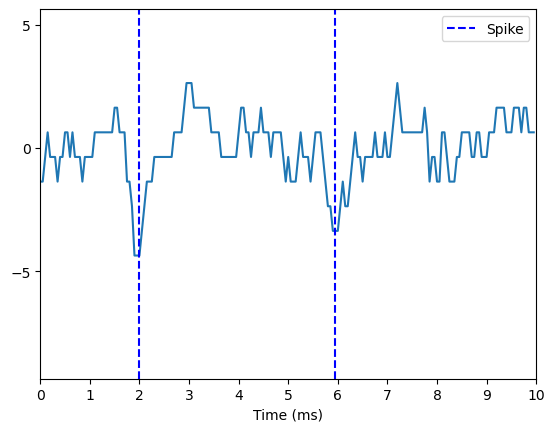

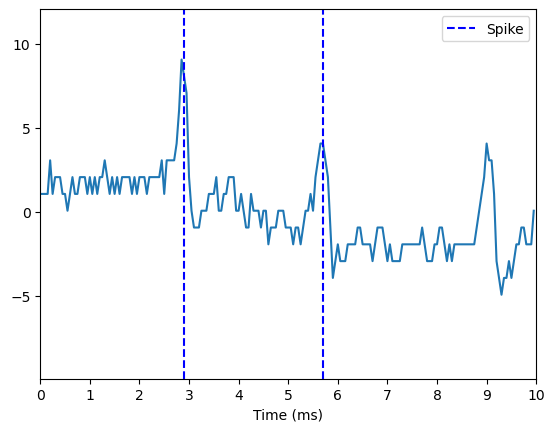

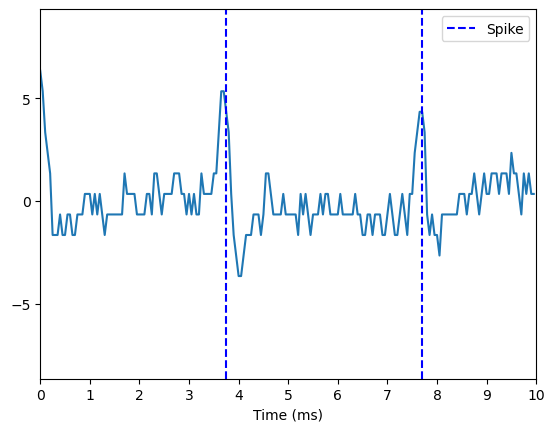

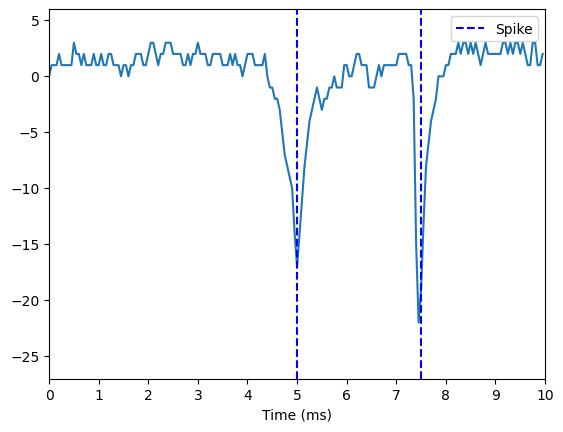

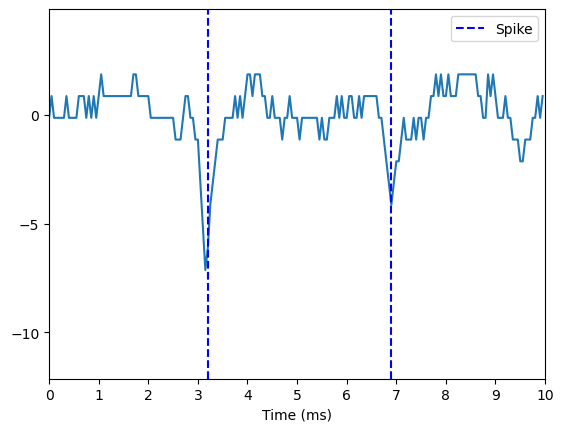

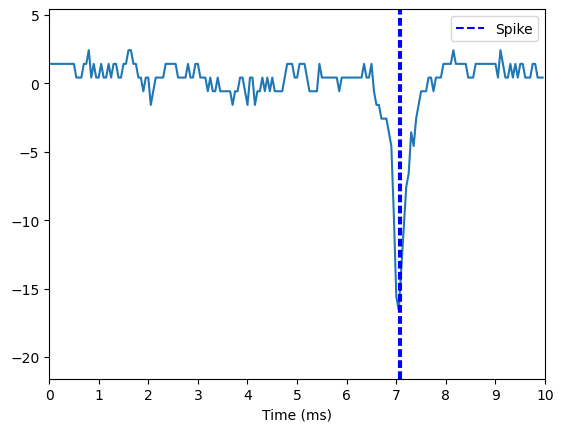

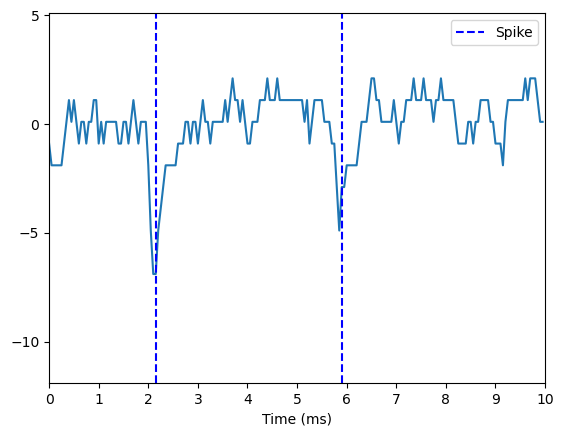

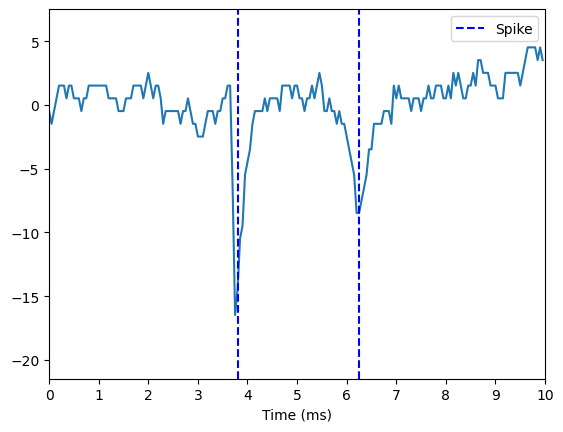

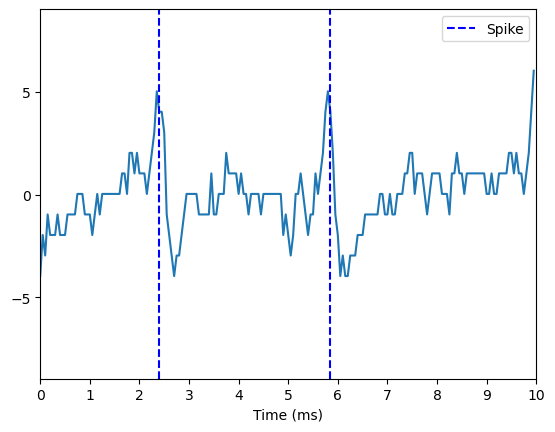

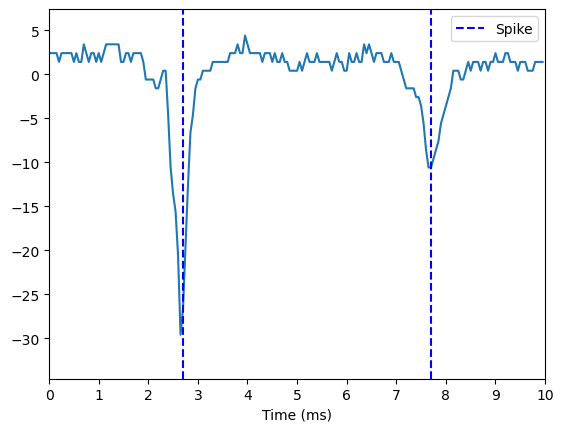

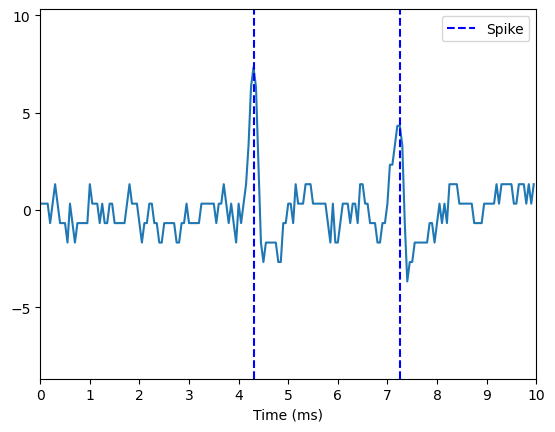

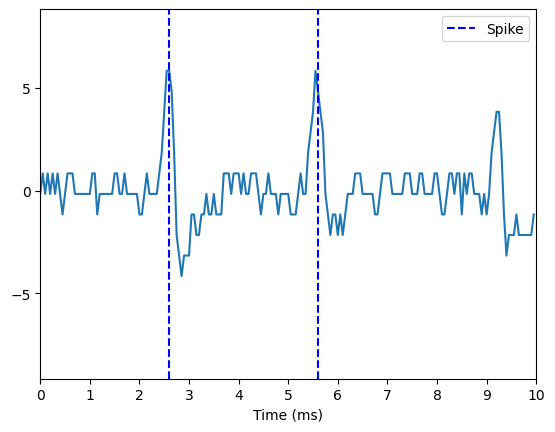

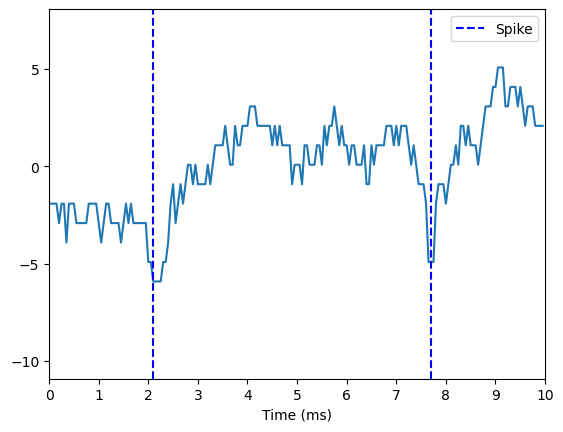

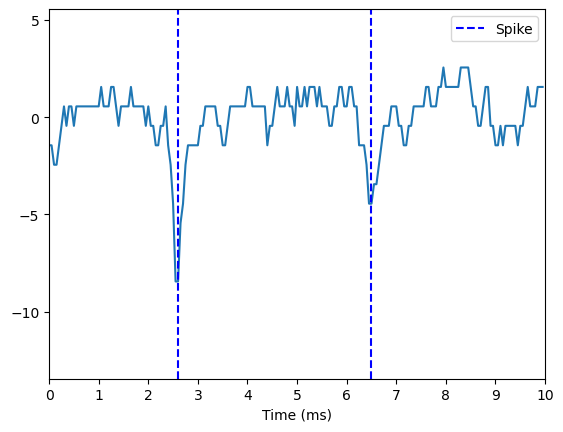

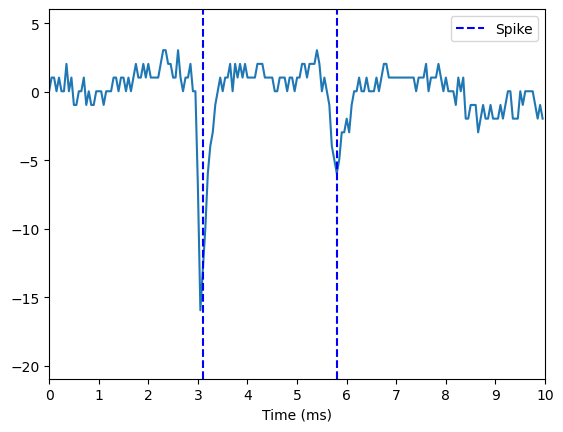

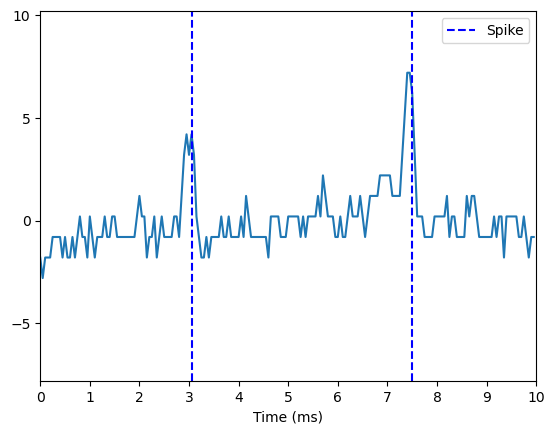

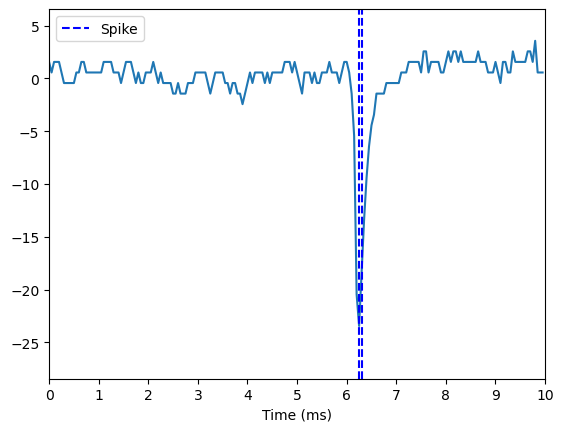

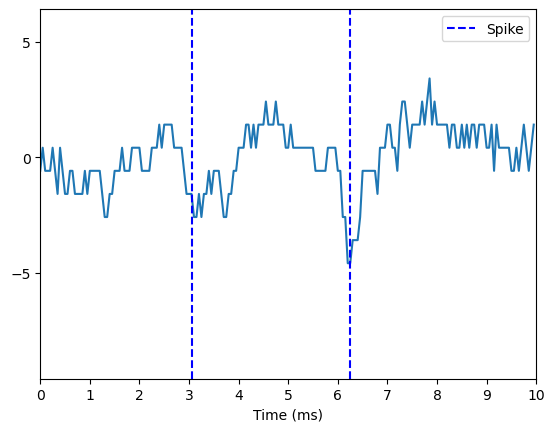

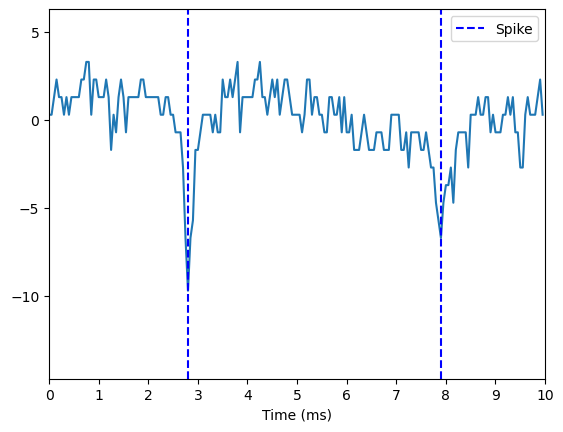

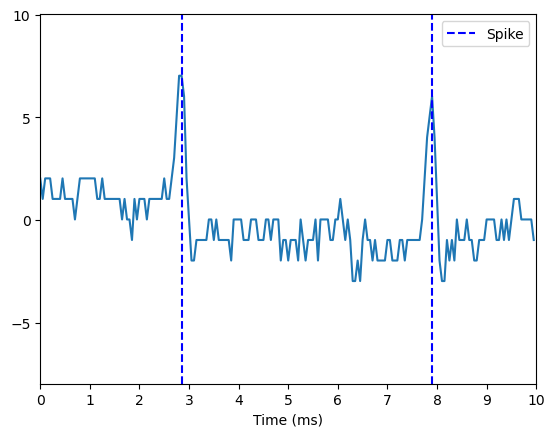

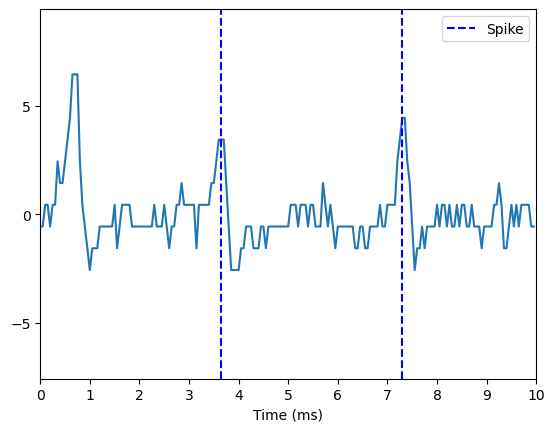

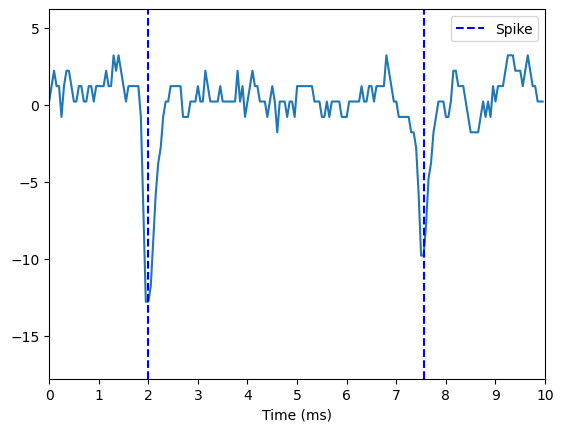

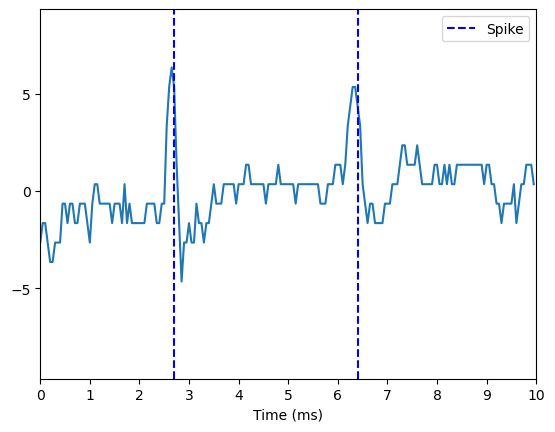

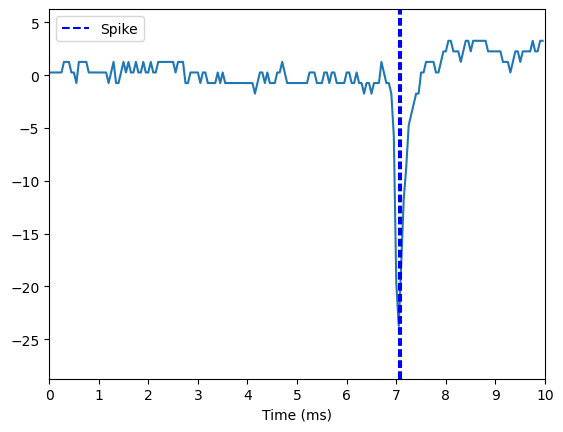

In [22]:
# Plot samples
NUM_SAMPLES = 25
random_seed(2)
##
for _ in range(NUM_SAMPLES):
    sample = rec_sampler.get_sample(has_wf=True)
    rec_sampler.plot_sample(*sample)

Using random seed 231


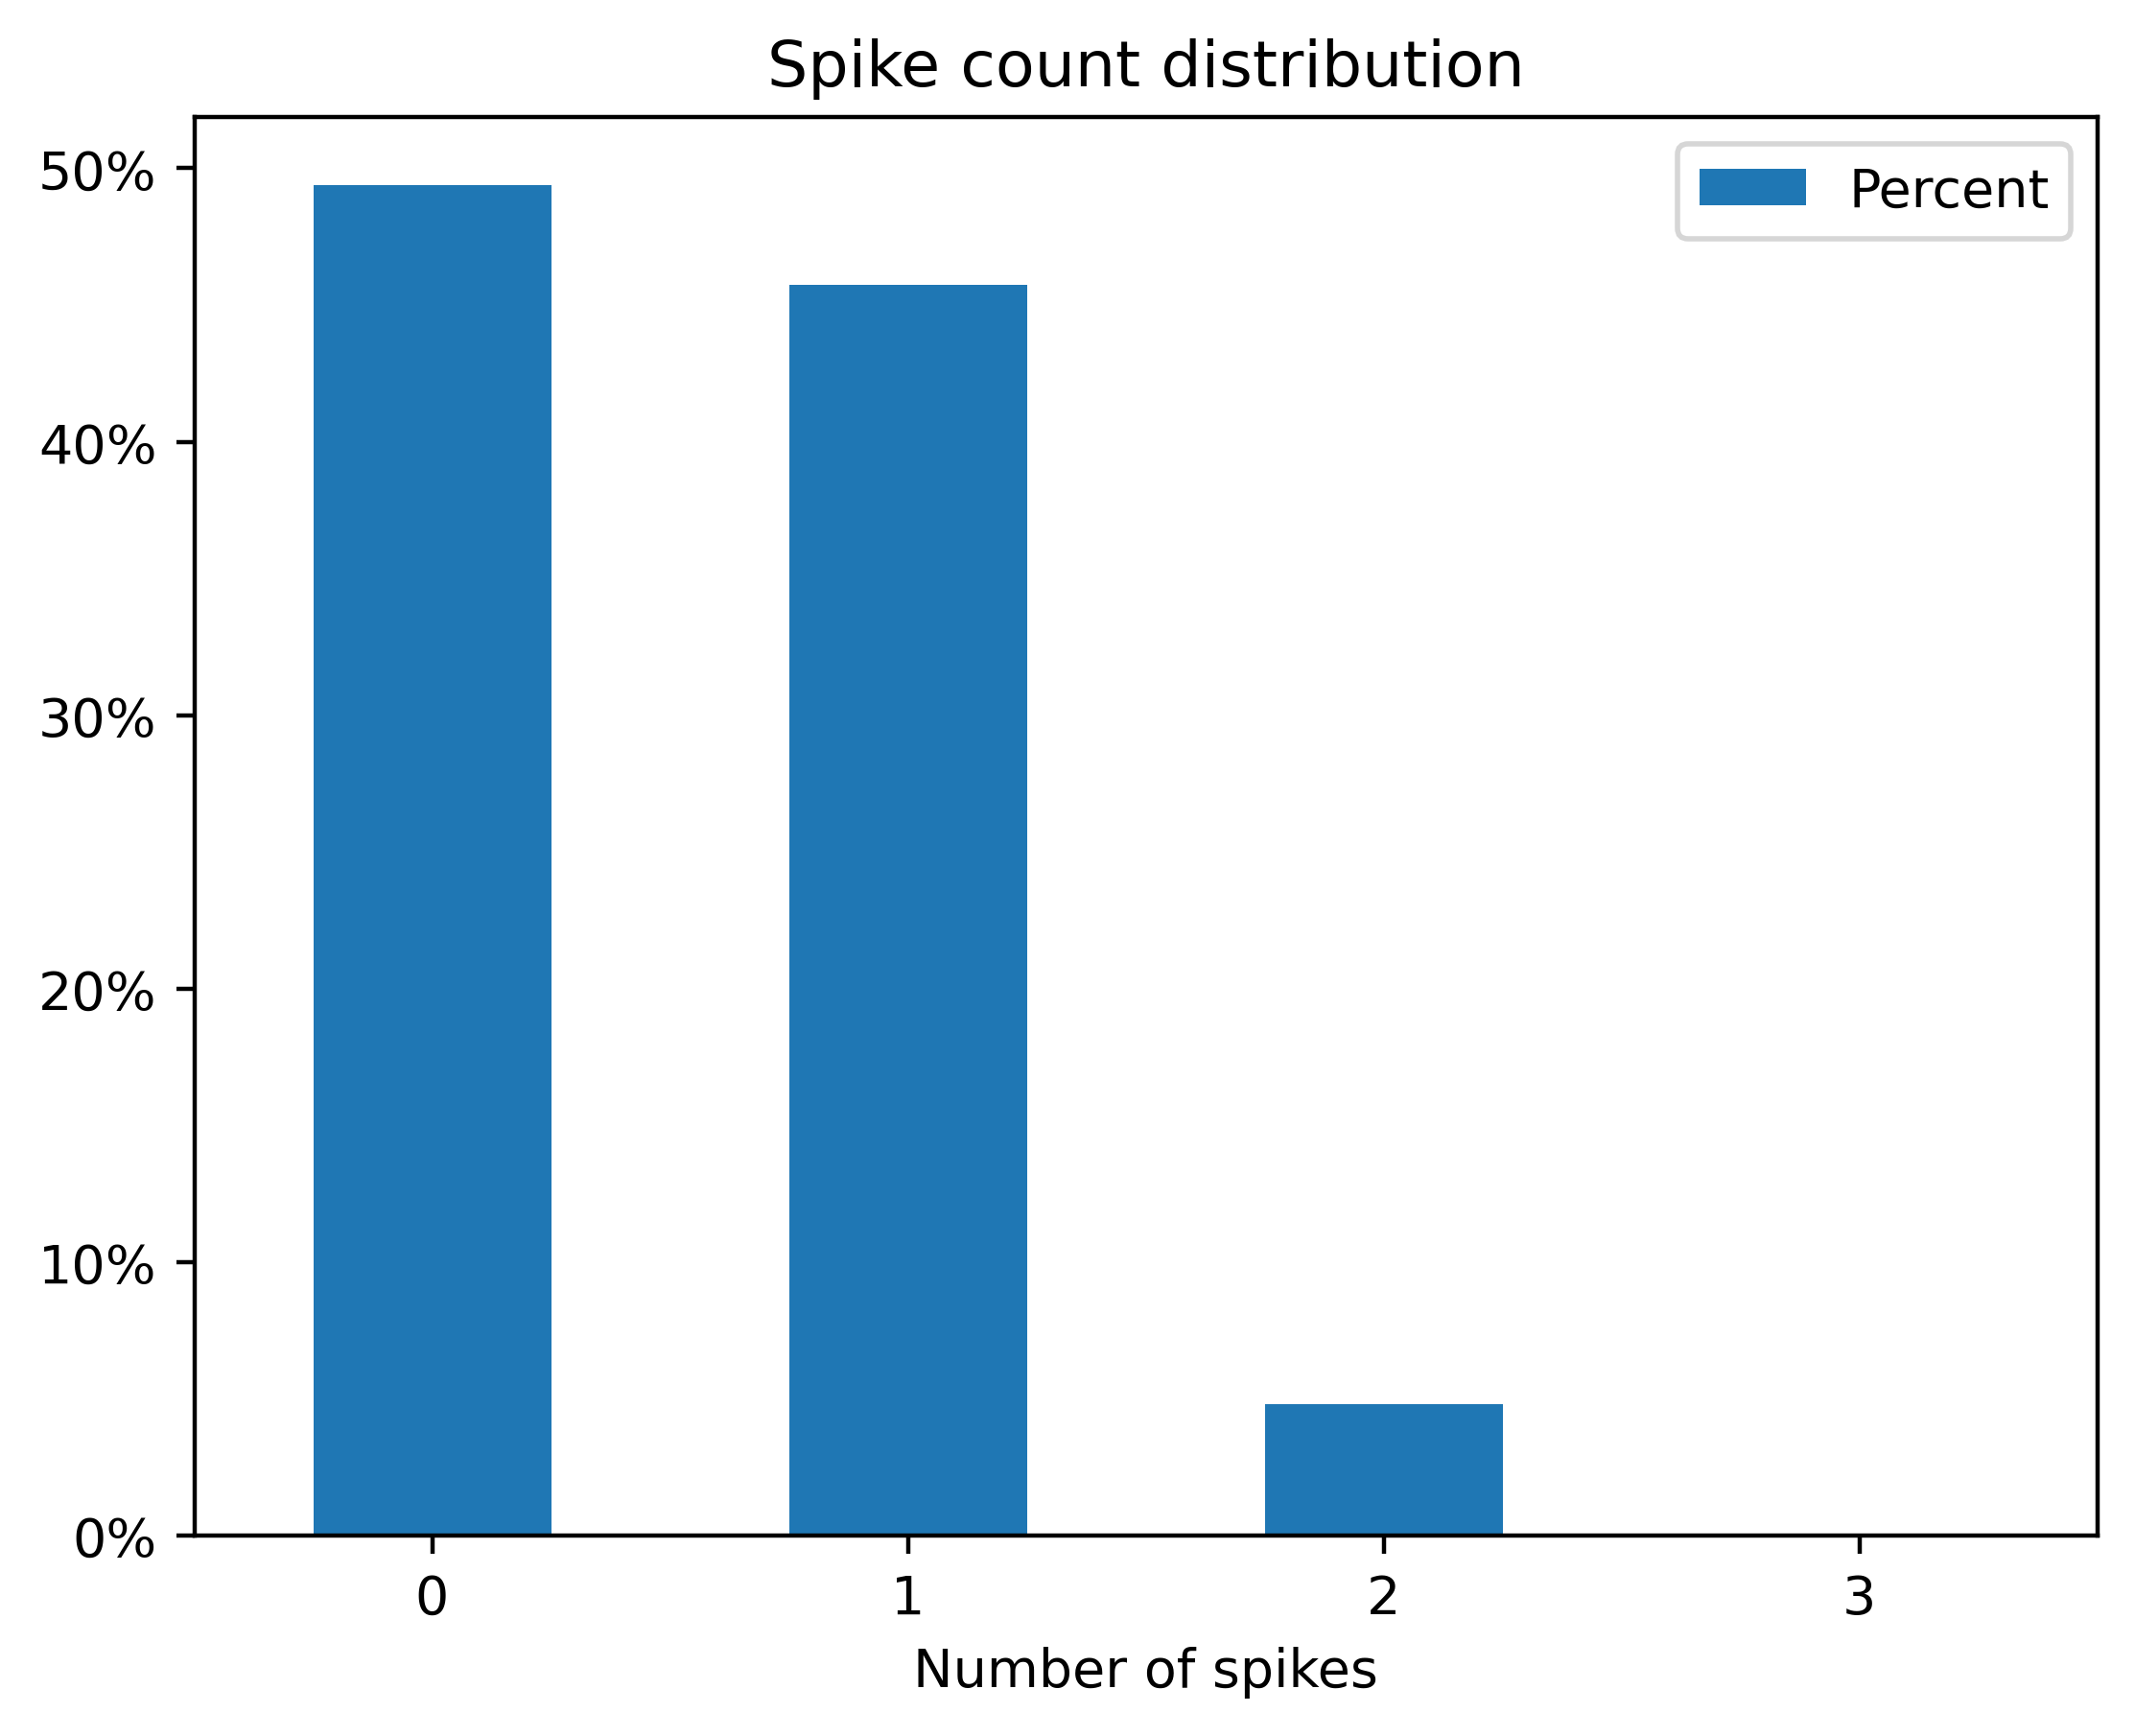

In [121]:
# Get distribution of number of spikes in each sample
NUM_SAMPLES = 10000
random_seed(231)
set_dpi(400)
##
# Get waveform count distribution
wf_counts = [0] * 15  # ith element = number of samples with i waveforms (*15 since there are probably not more than 14 spikes in a sample)
for _ in range(NUM_SAMPLES):
    _, num_wfs, _, _ = rec_sampler.get_sample()
    wf_counts[num_wfs.item()] += 1

# Get maximum number of waveforms in a sample
for i in range(len(wf_counts)-1, -1, -1):
    if wf_counts[i] > 0:
        i += 1
        break
wf_counts = wf_counts[:i]
total = sum(wf_counts)
wf_counts = [c / total * 100 for c in wf_counts]

# Plot
df = DataFrame(data={"Percent": wf_counts}, index=range(len(wf_counts)))
df.plot.bar(rot=0)
plt.title("Spike count distribution")
yticks_locs = plt.yticks()[0]
yticks_labels = [f"{y:.0f}%" for y in yticks_locs if y <= 50]
plt.yticks(yticks_locs[:len(yticks_labels)], yticks_labels)
plt.xlabel("Number of spikes")
plt.show()

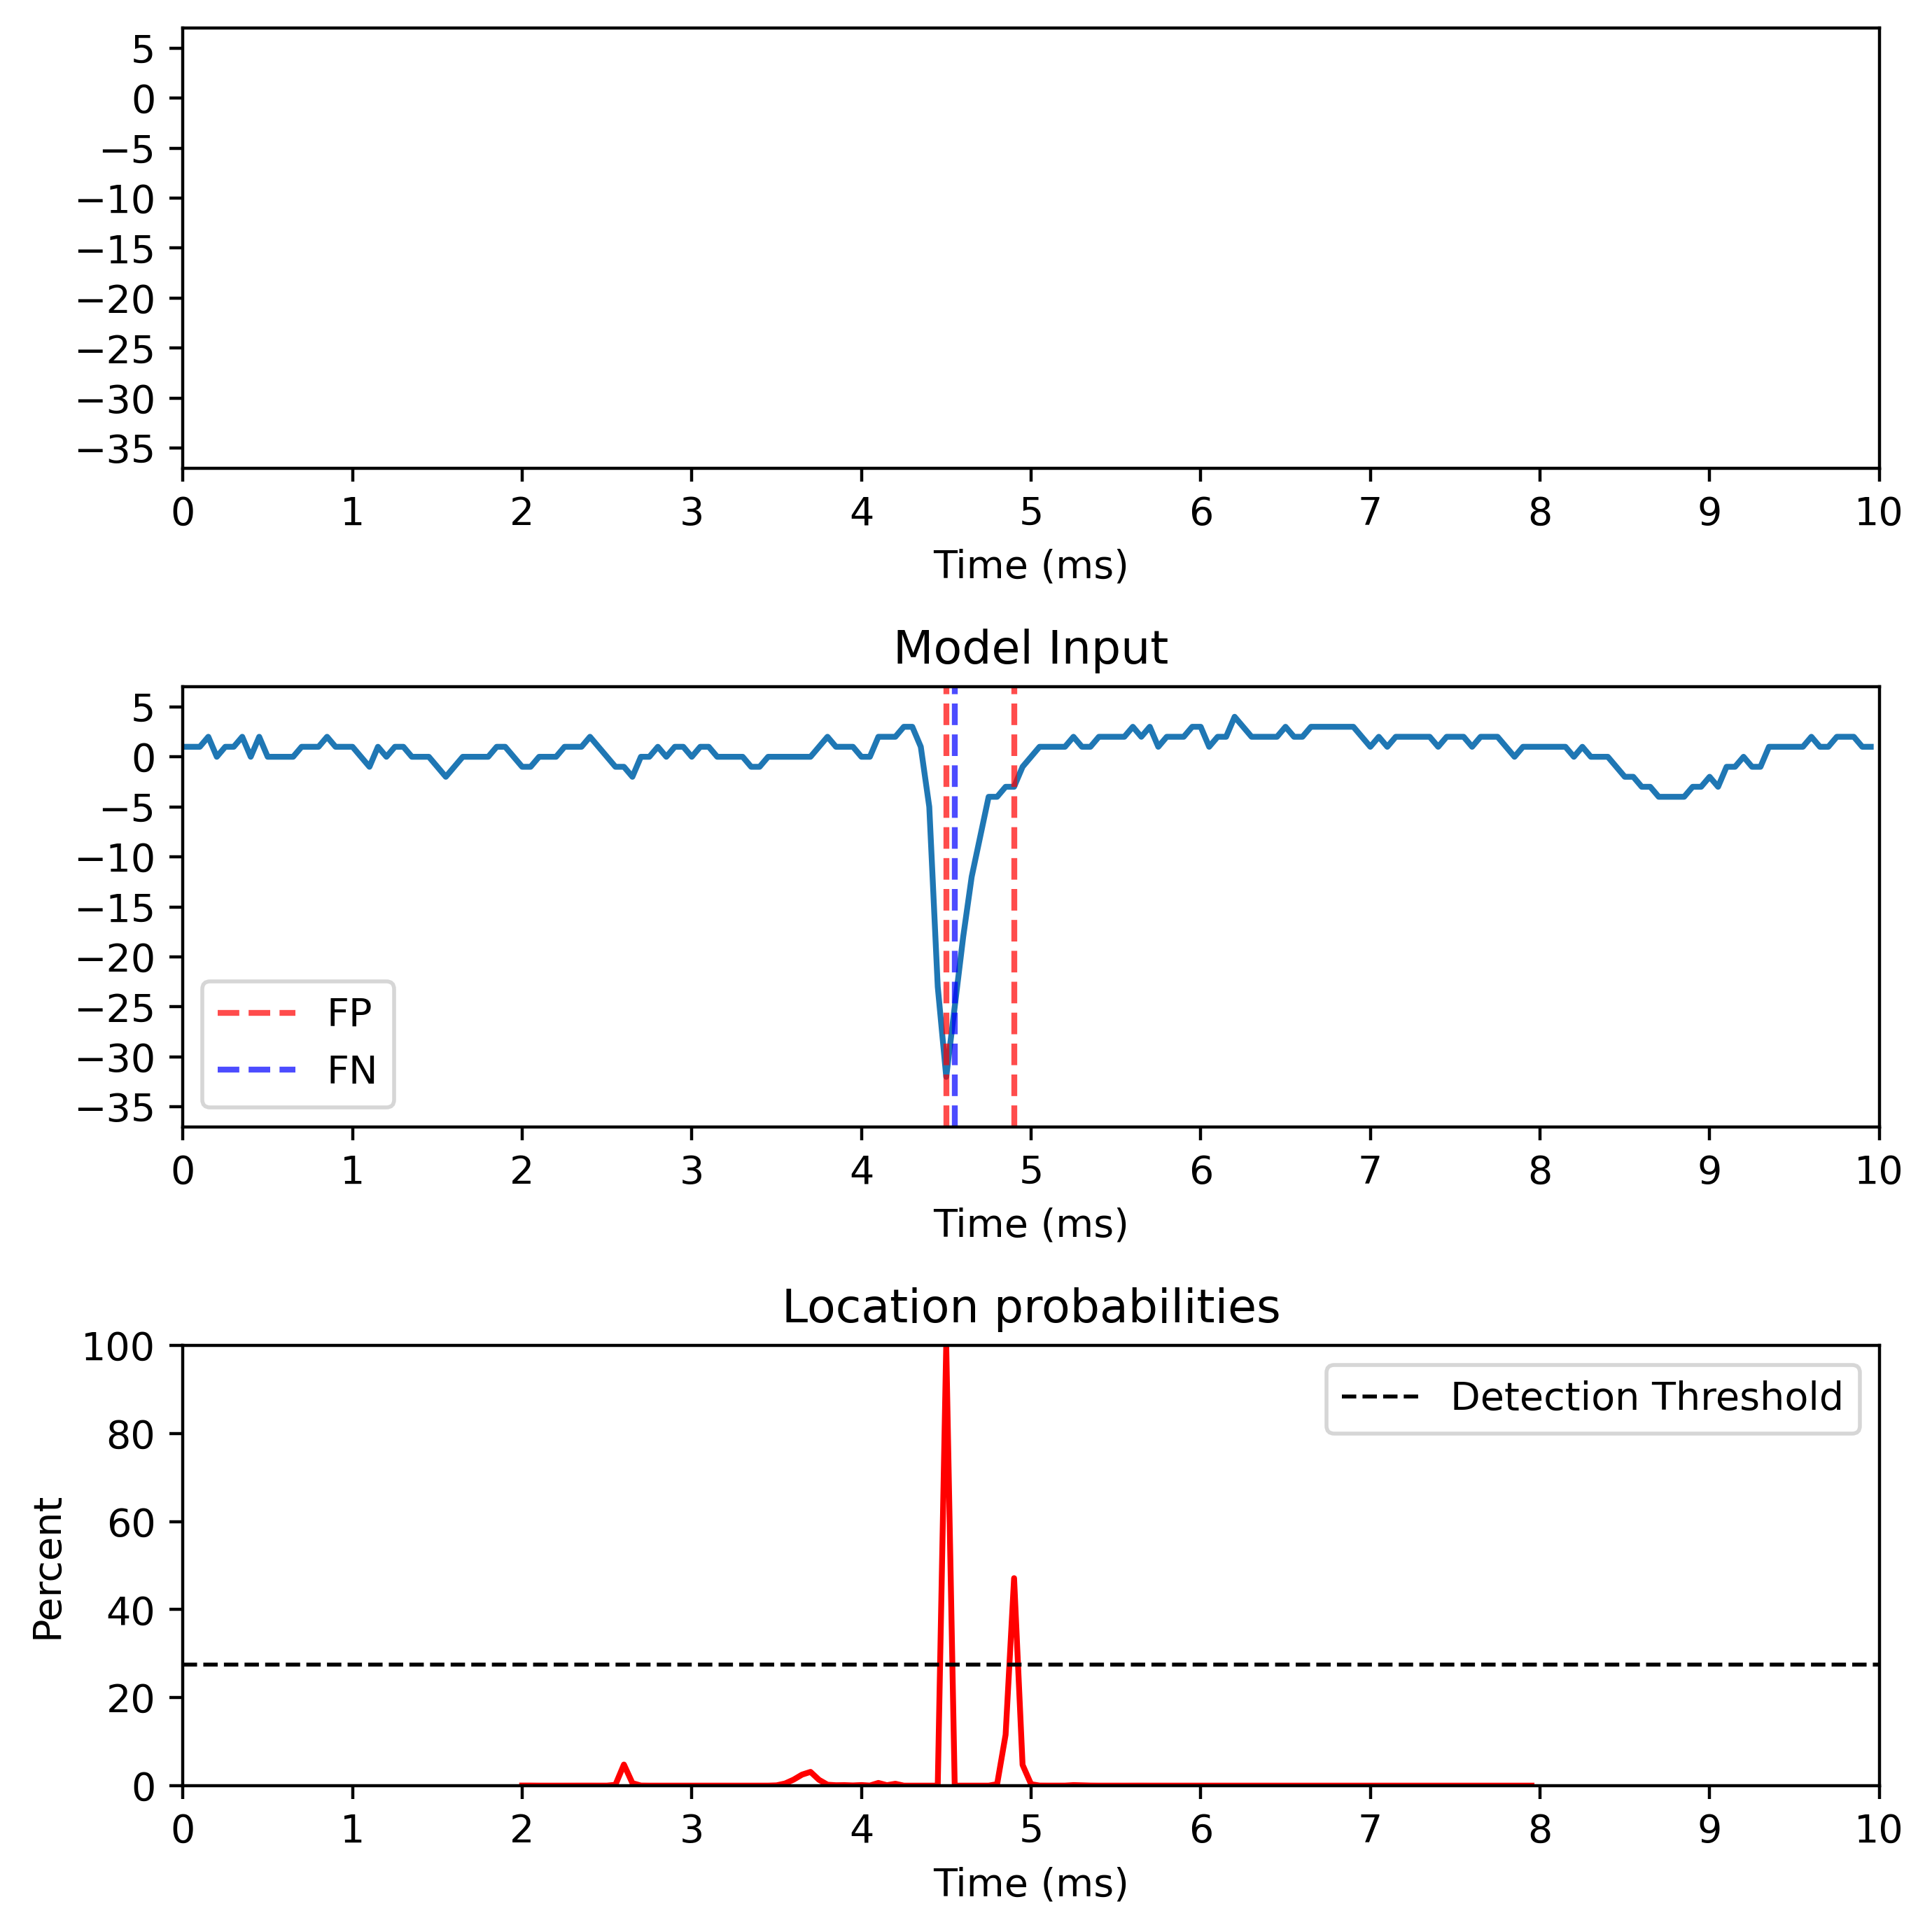

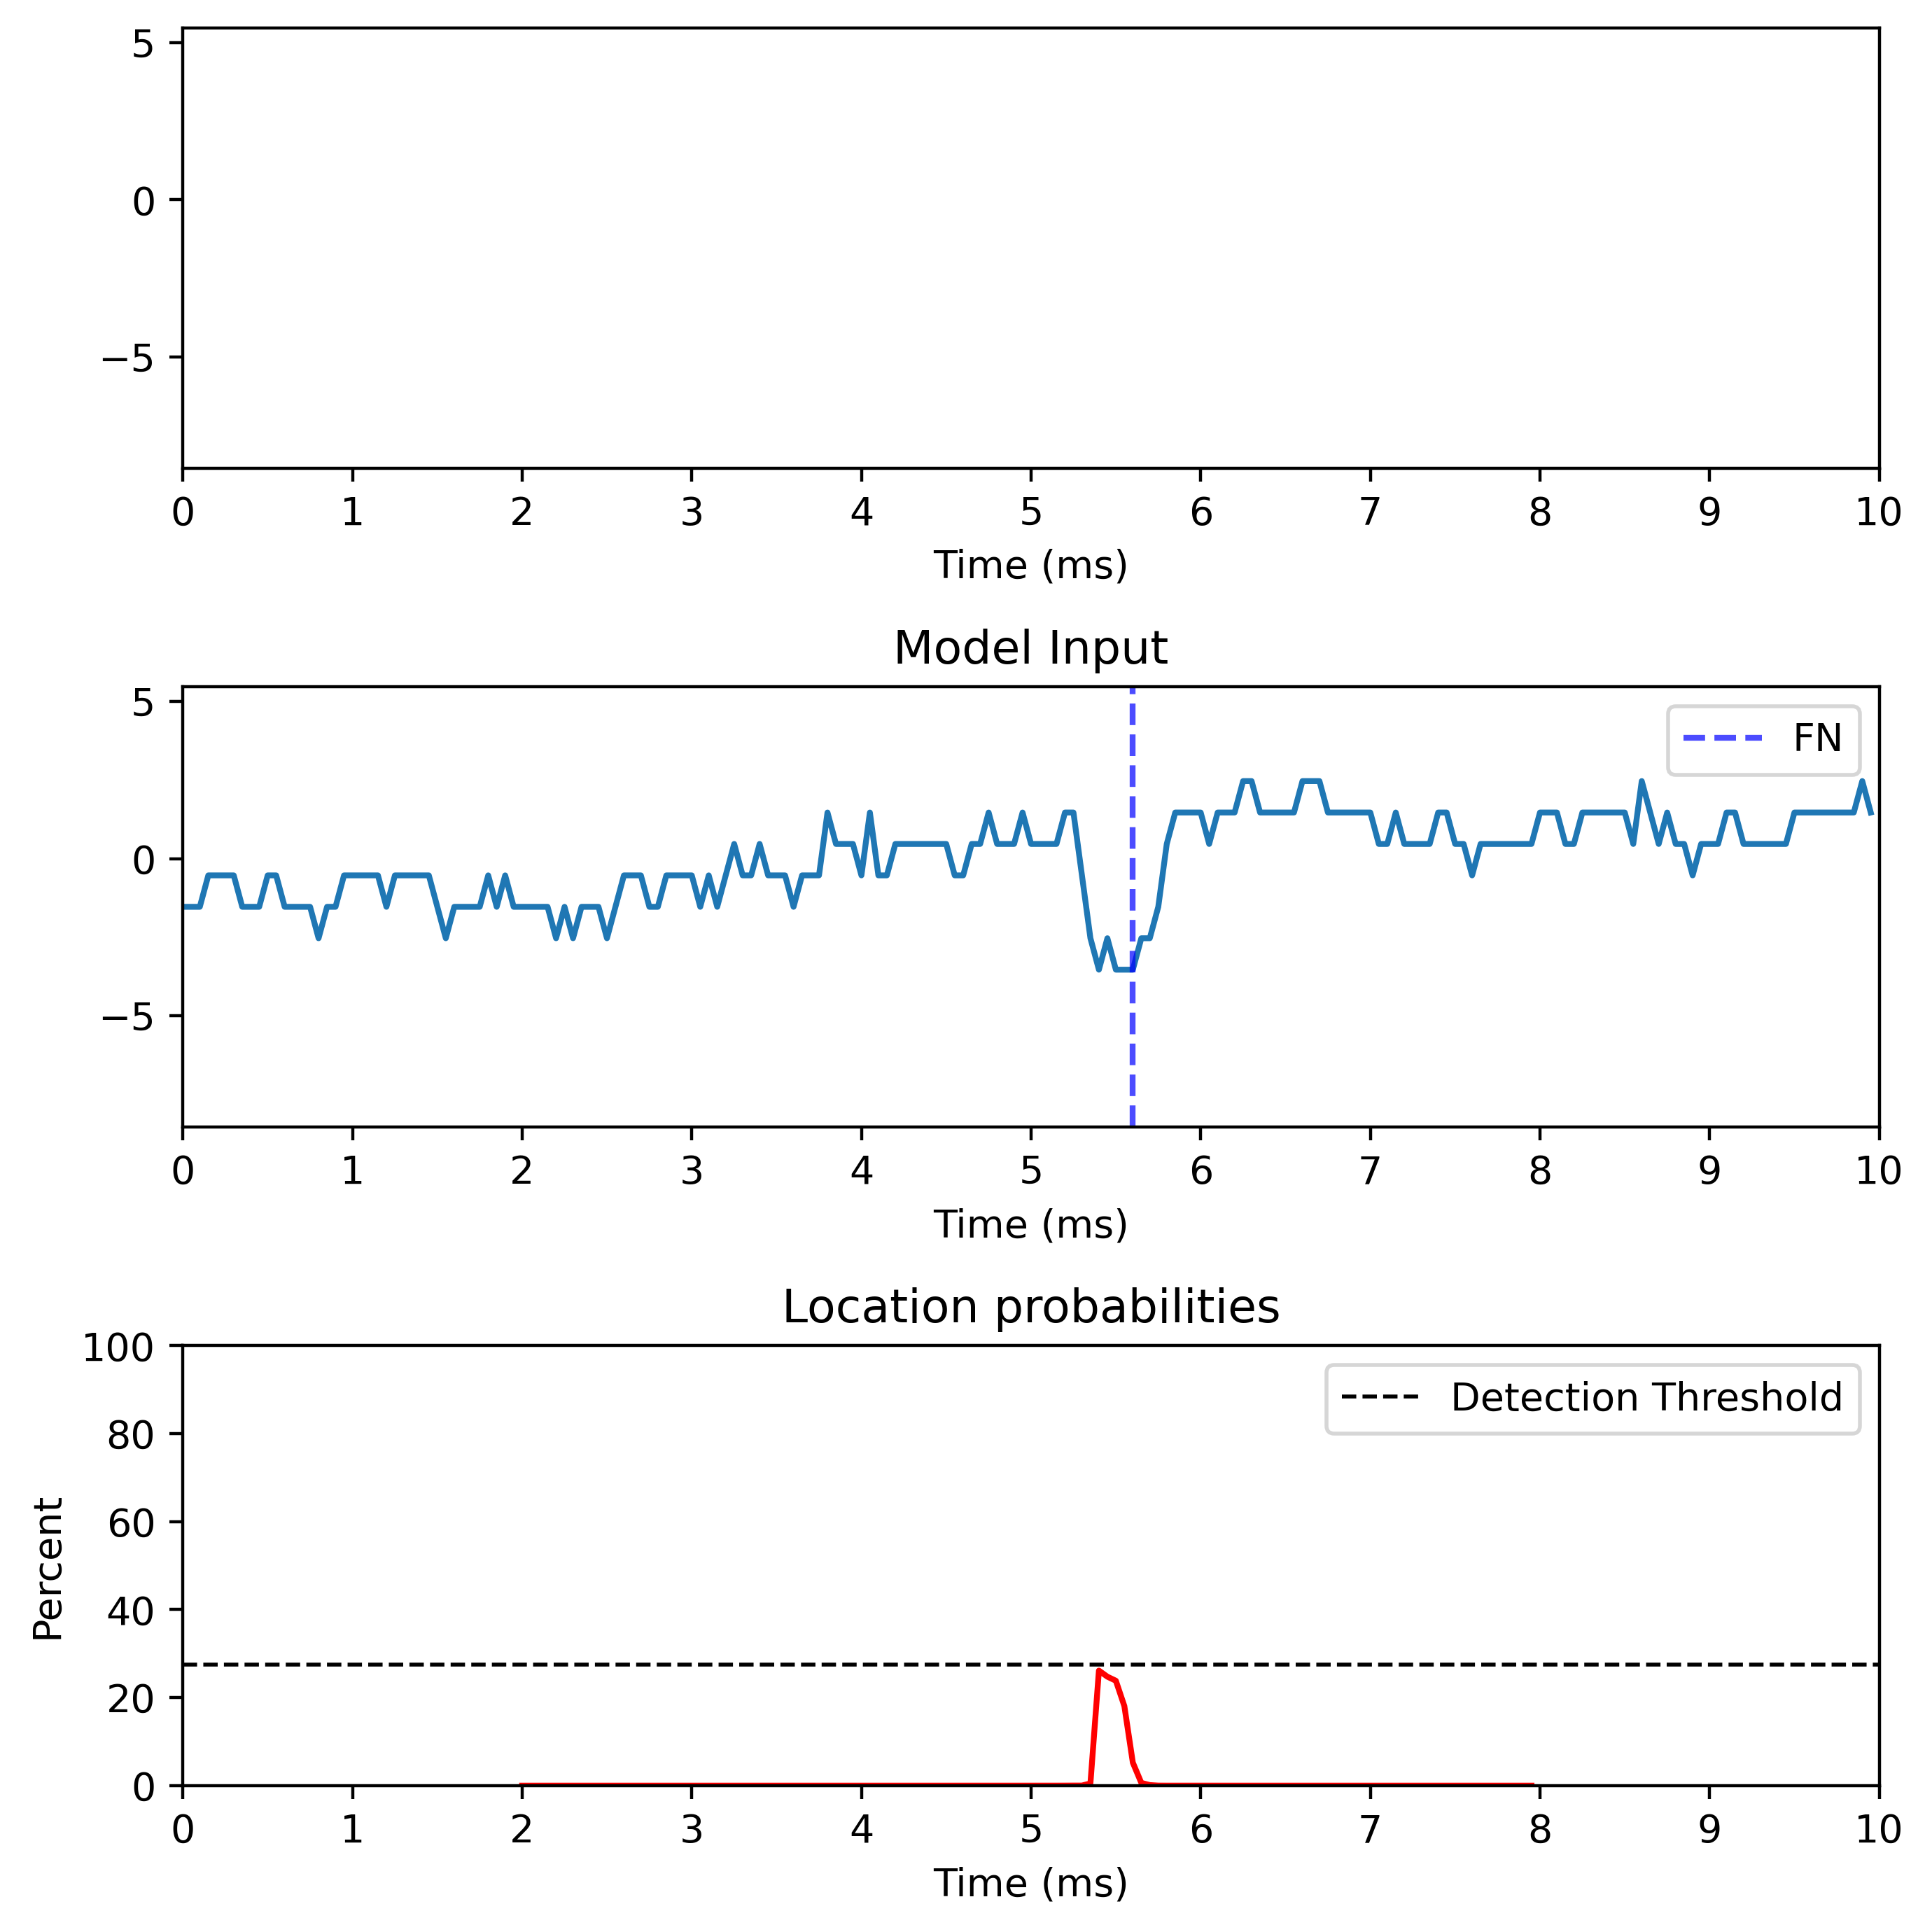

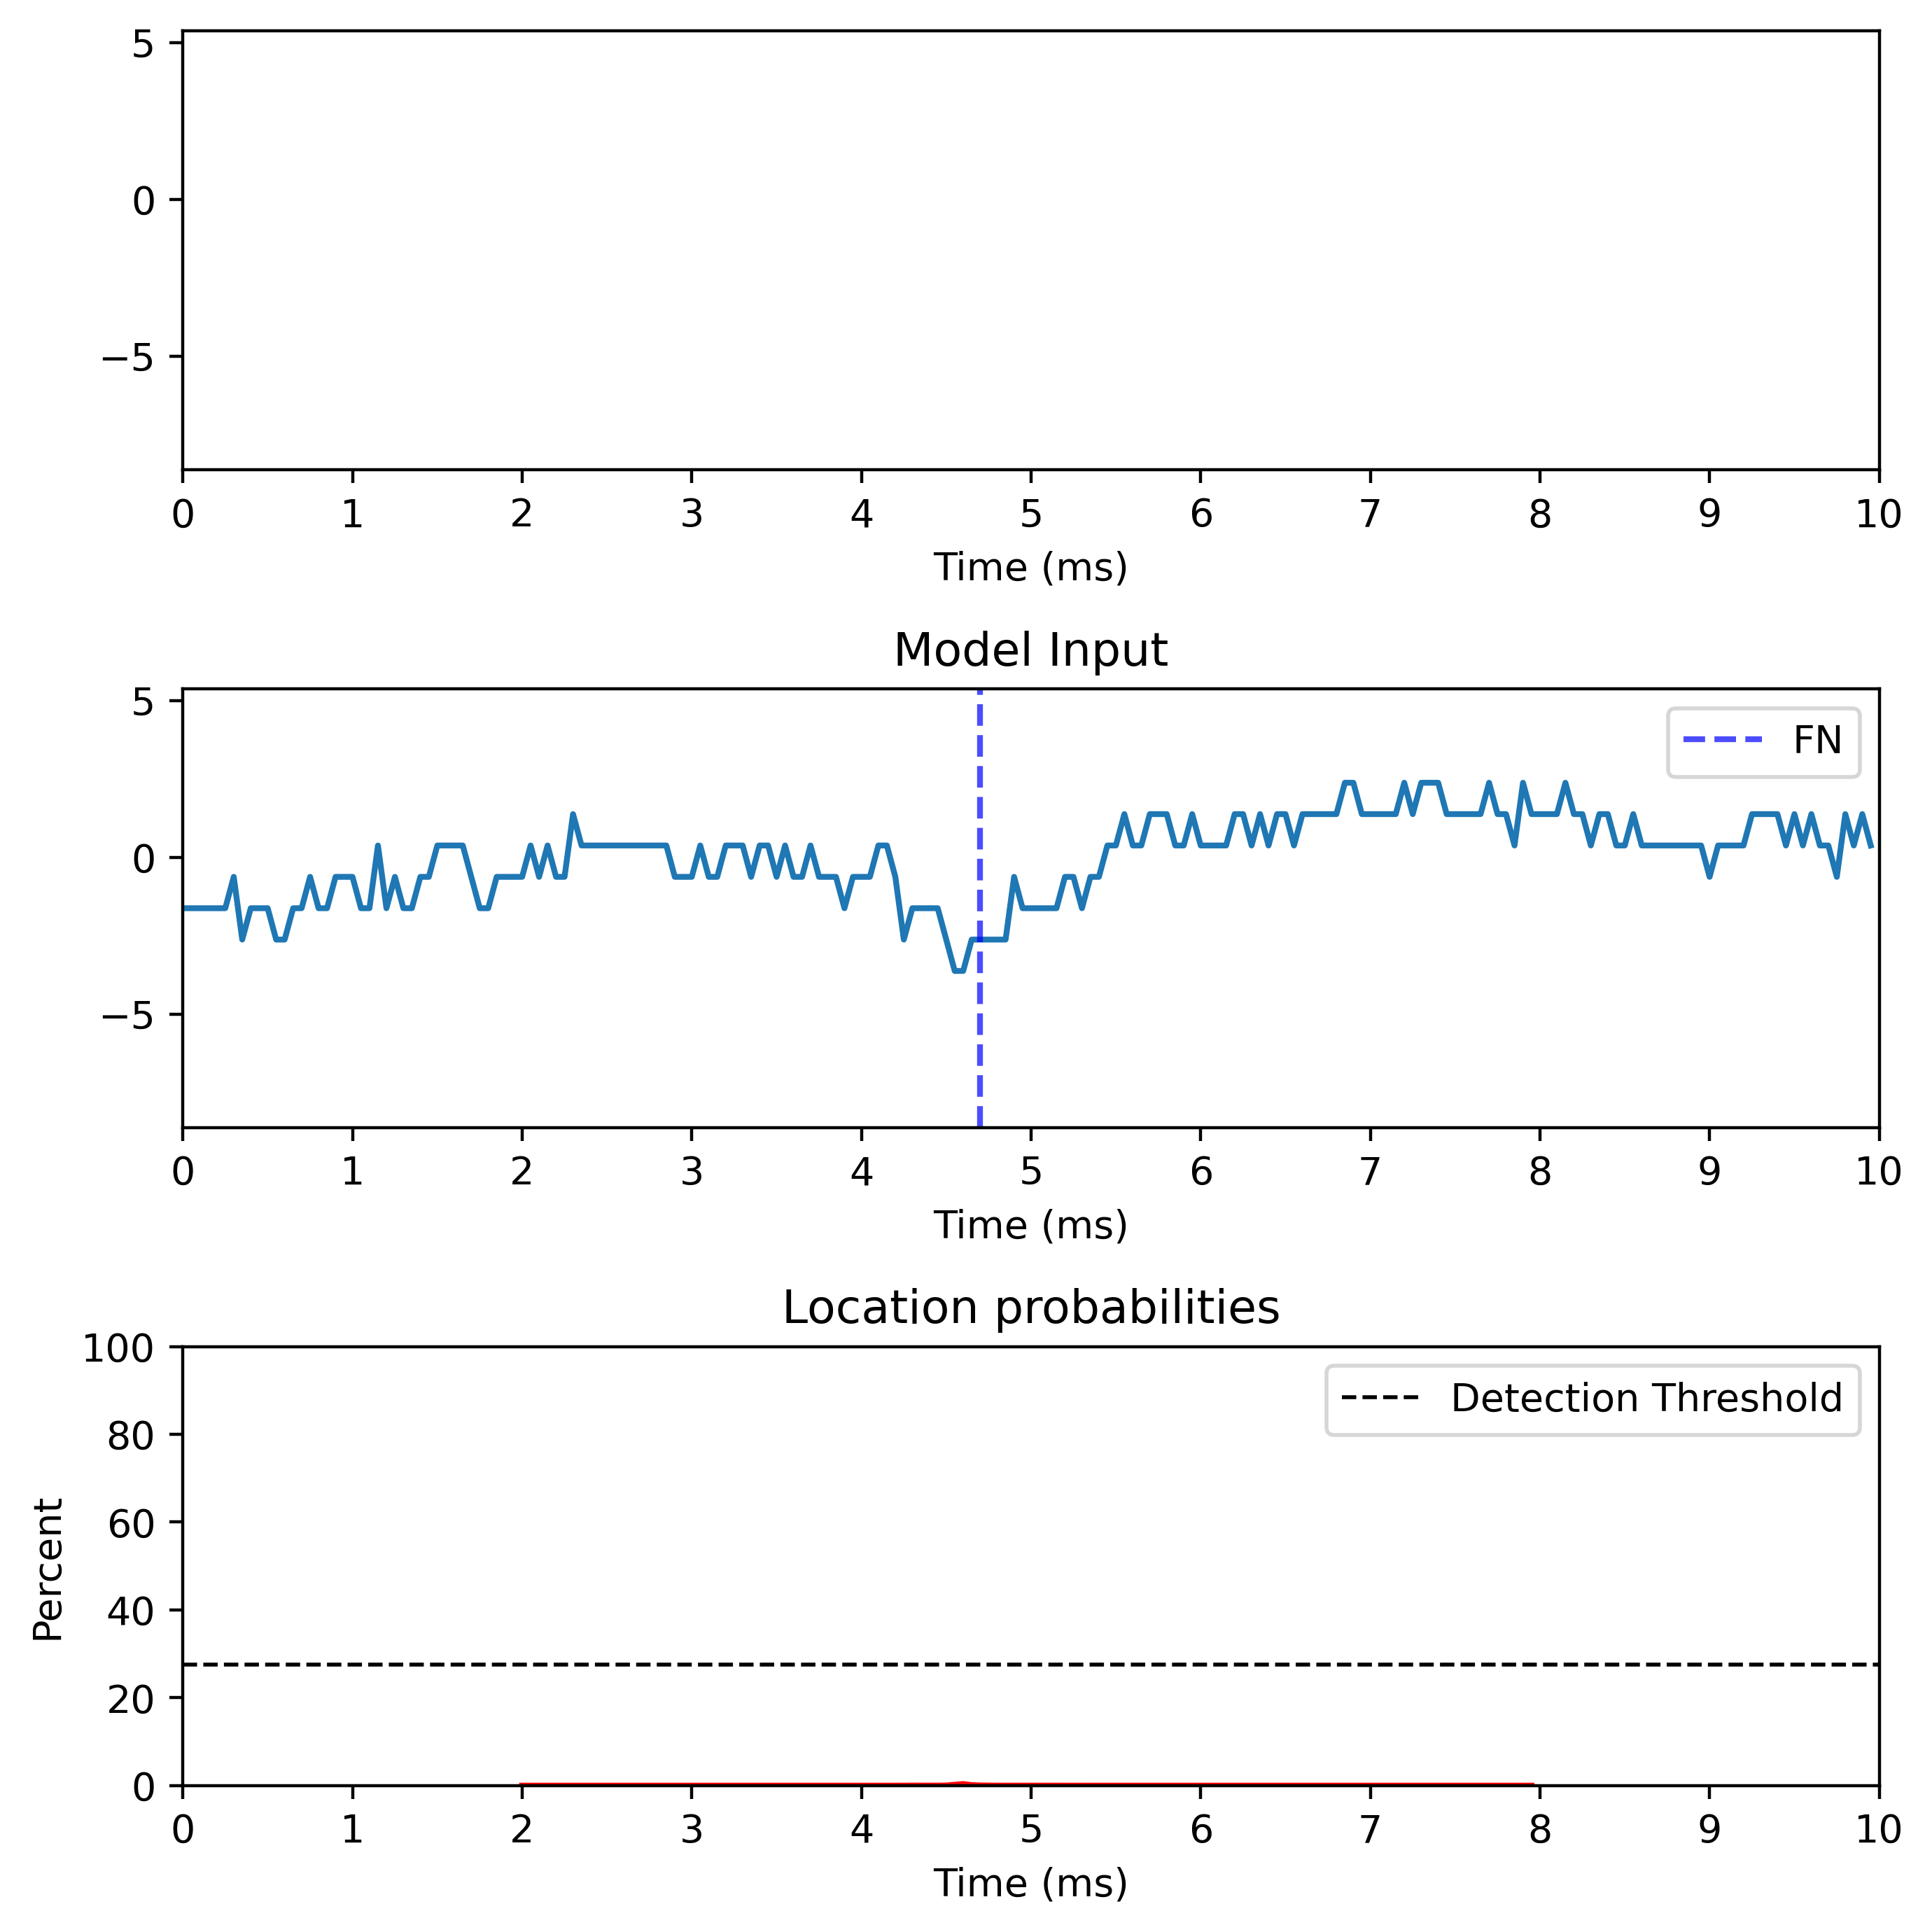

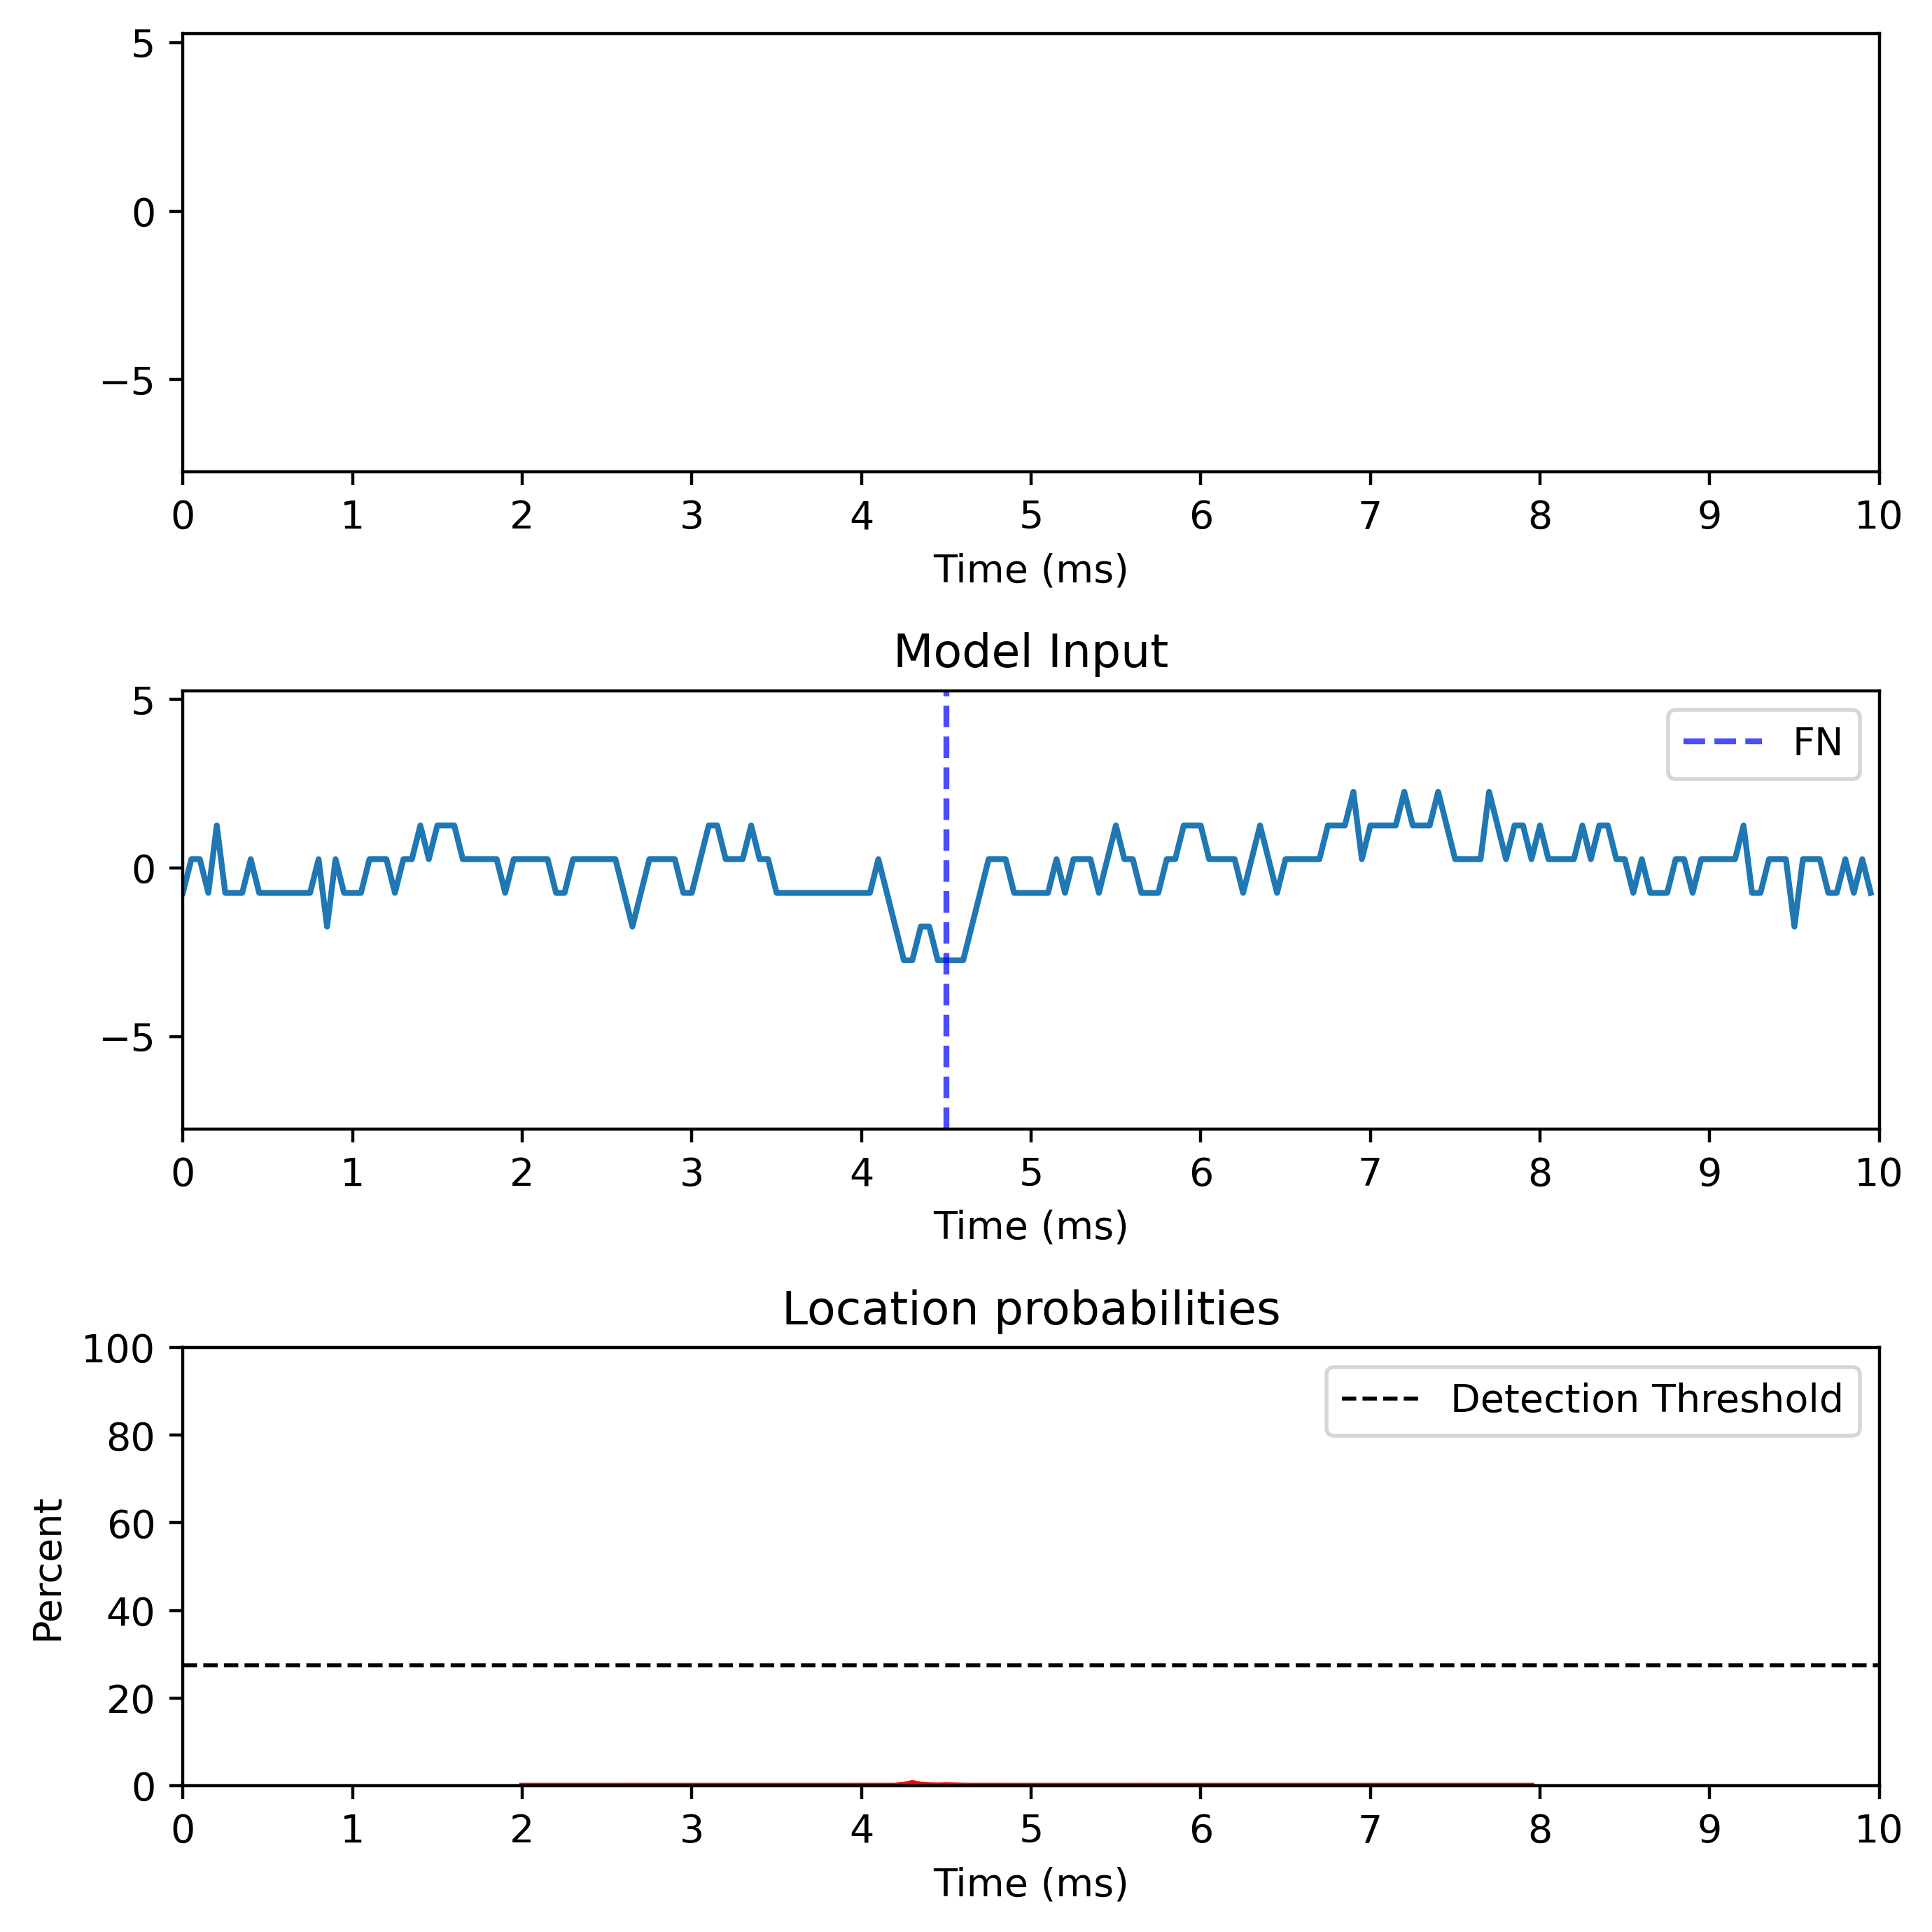

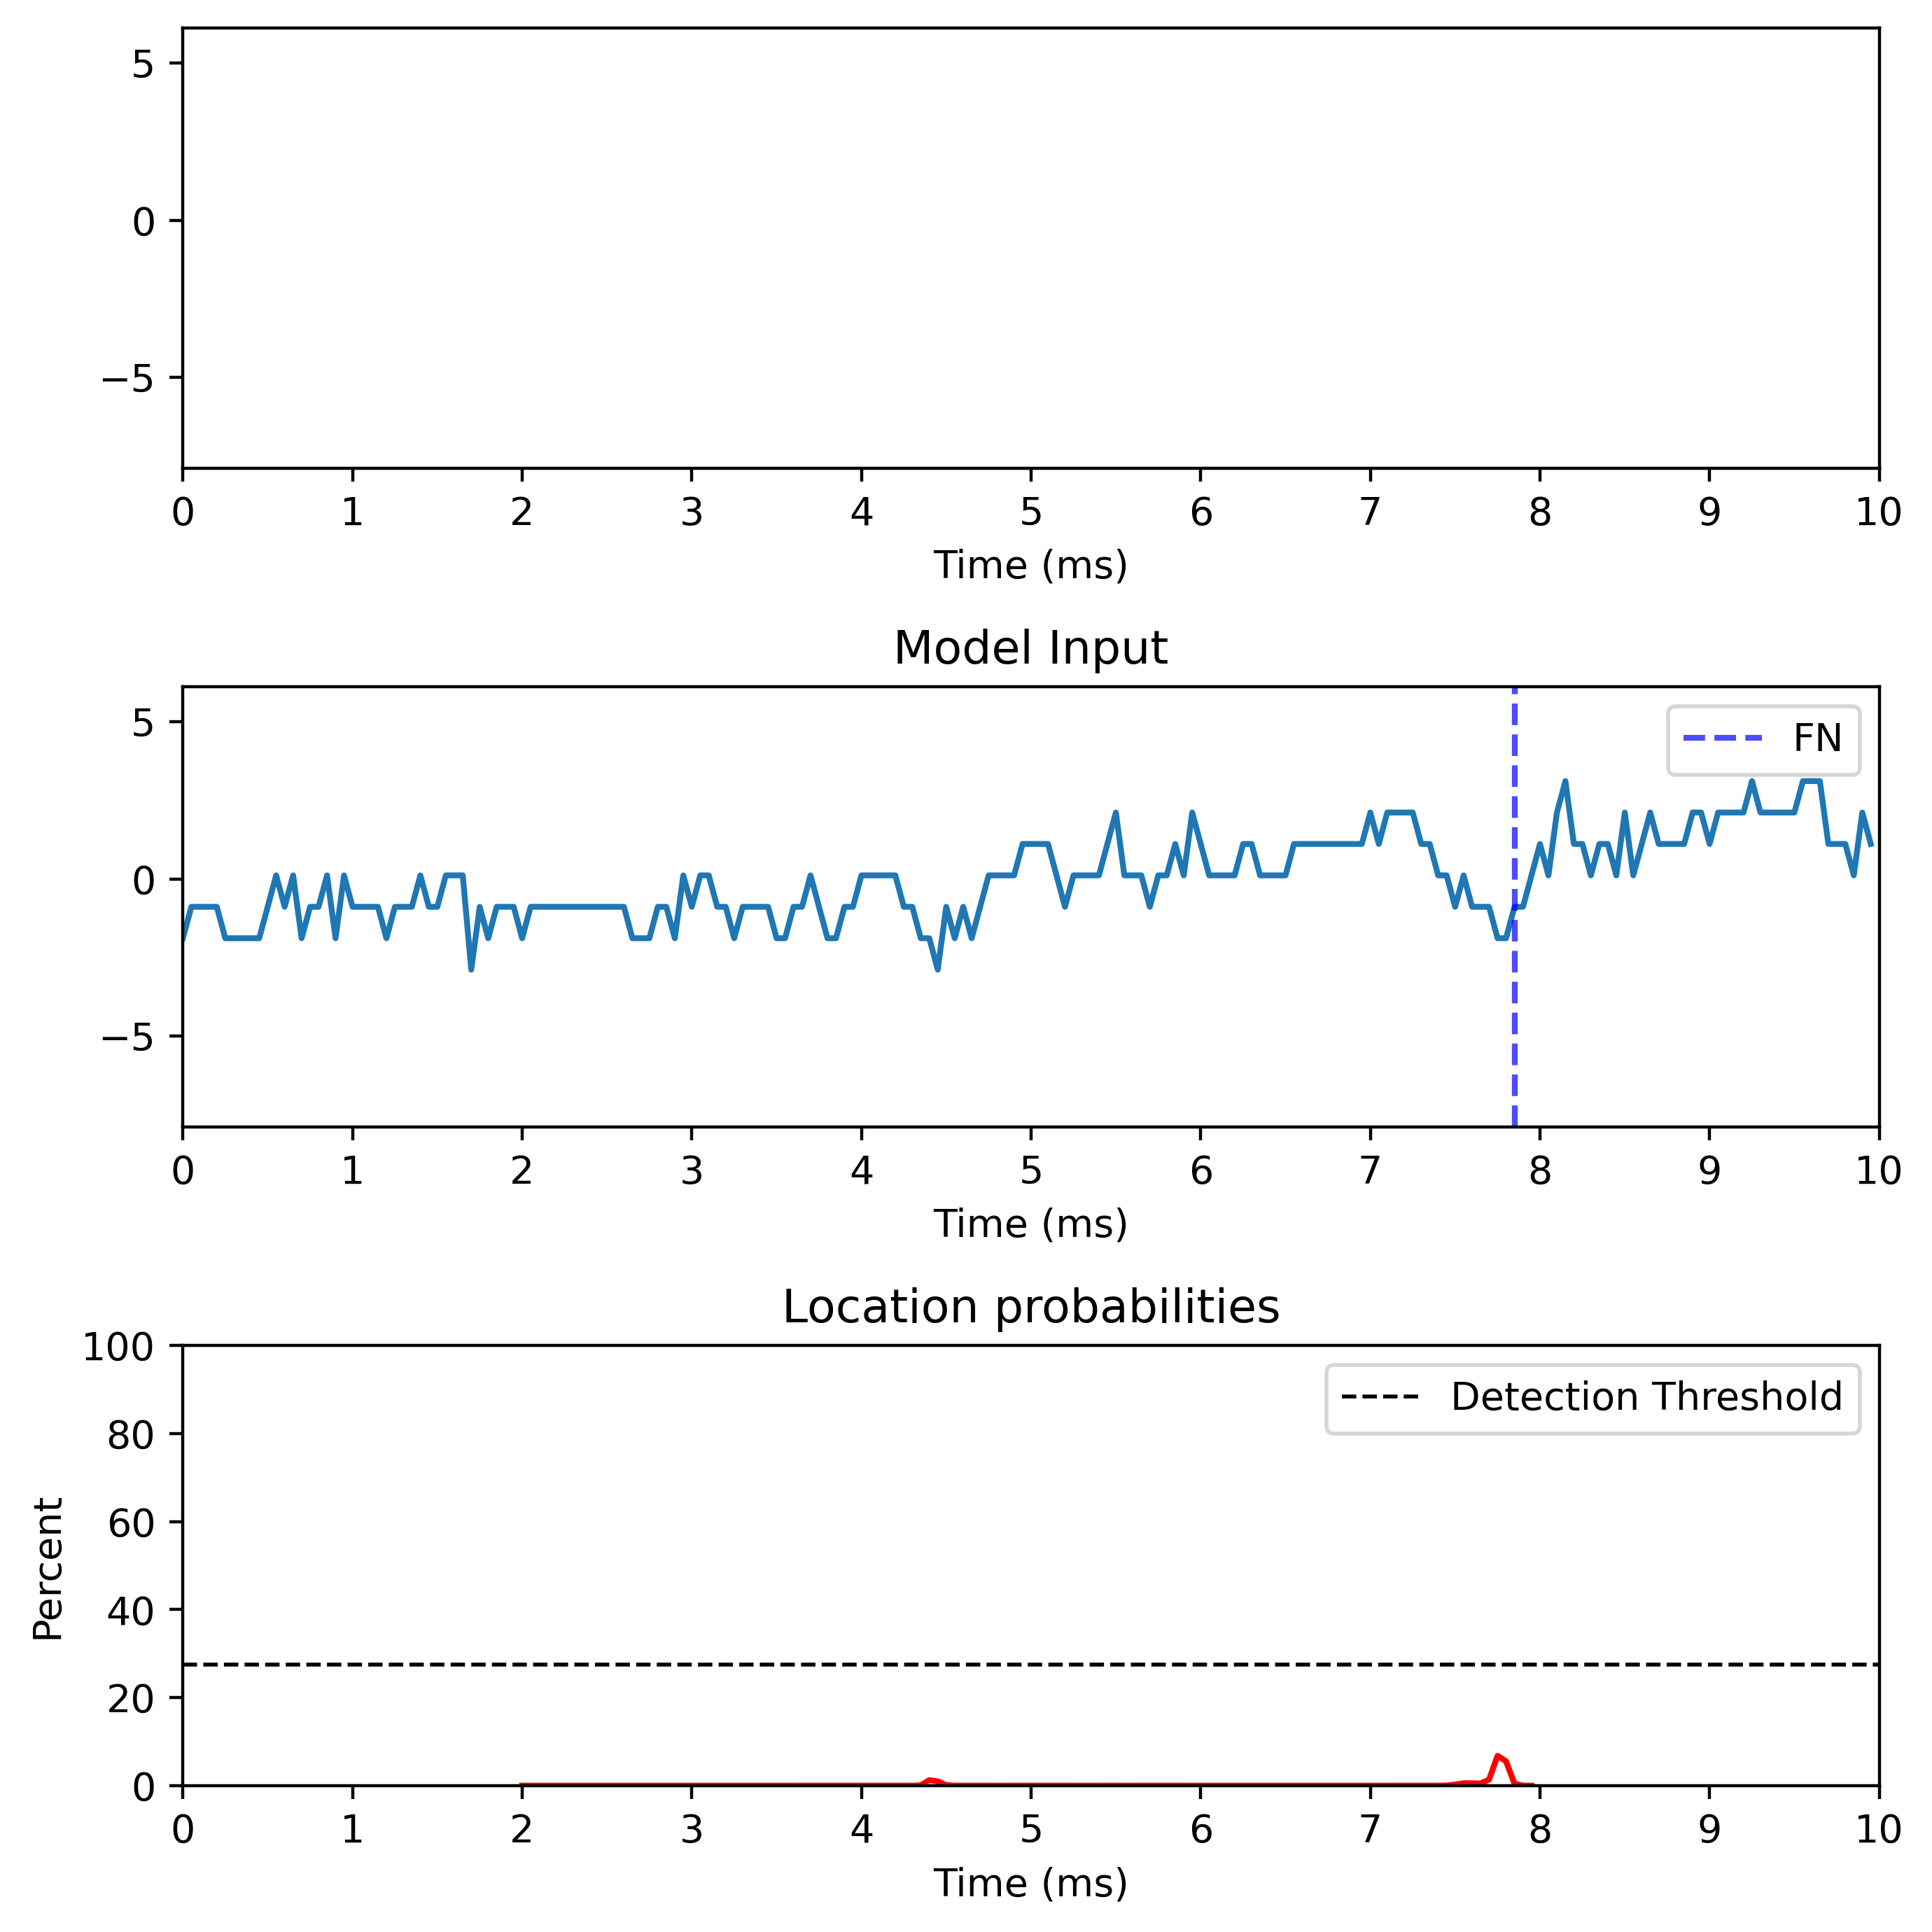

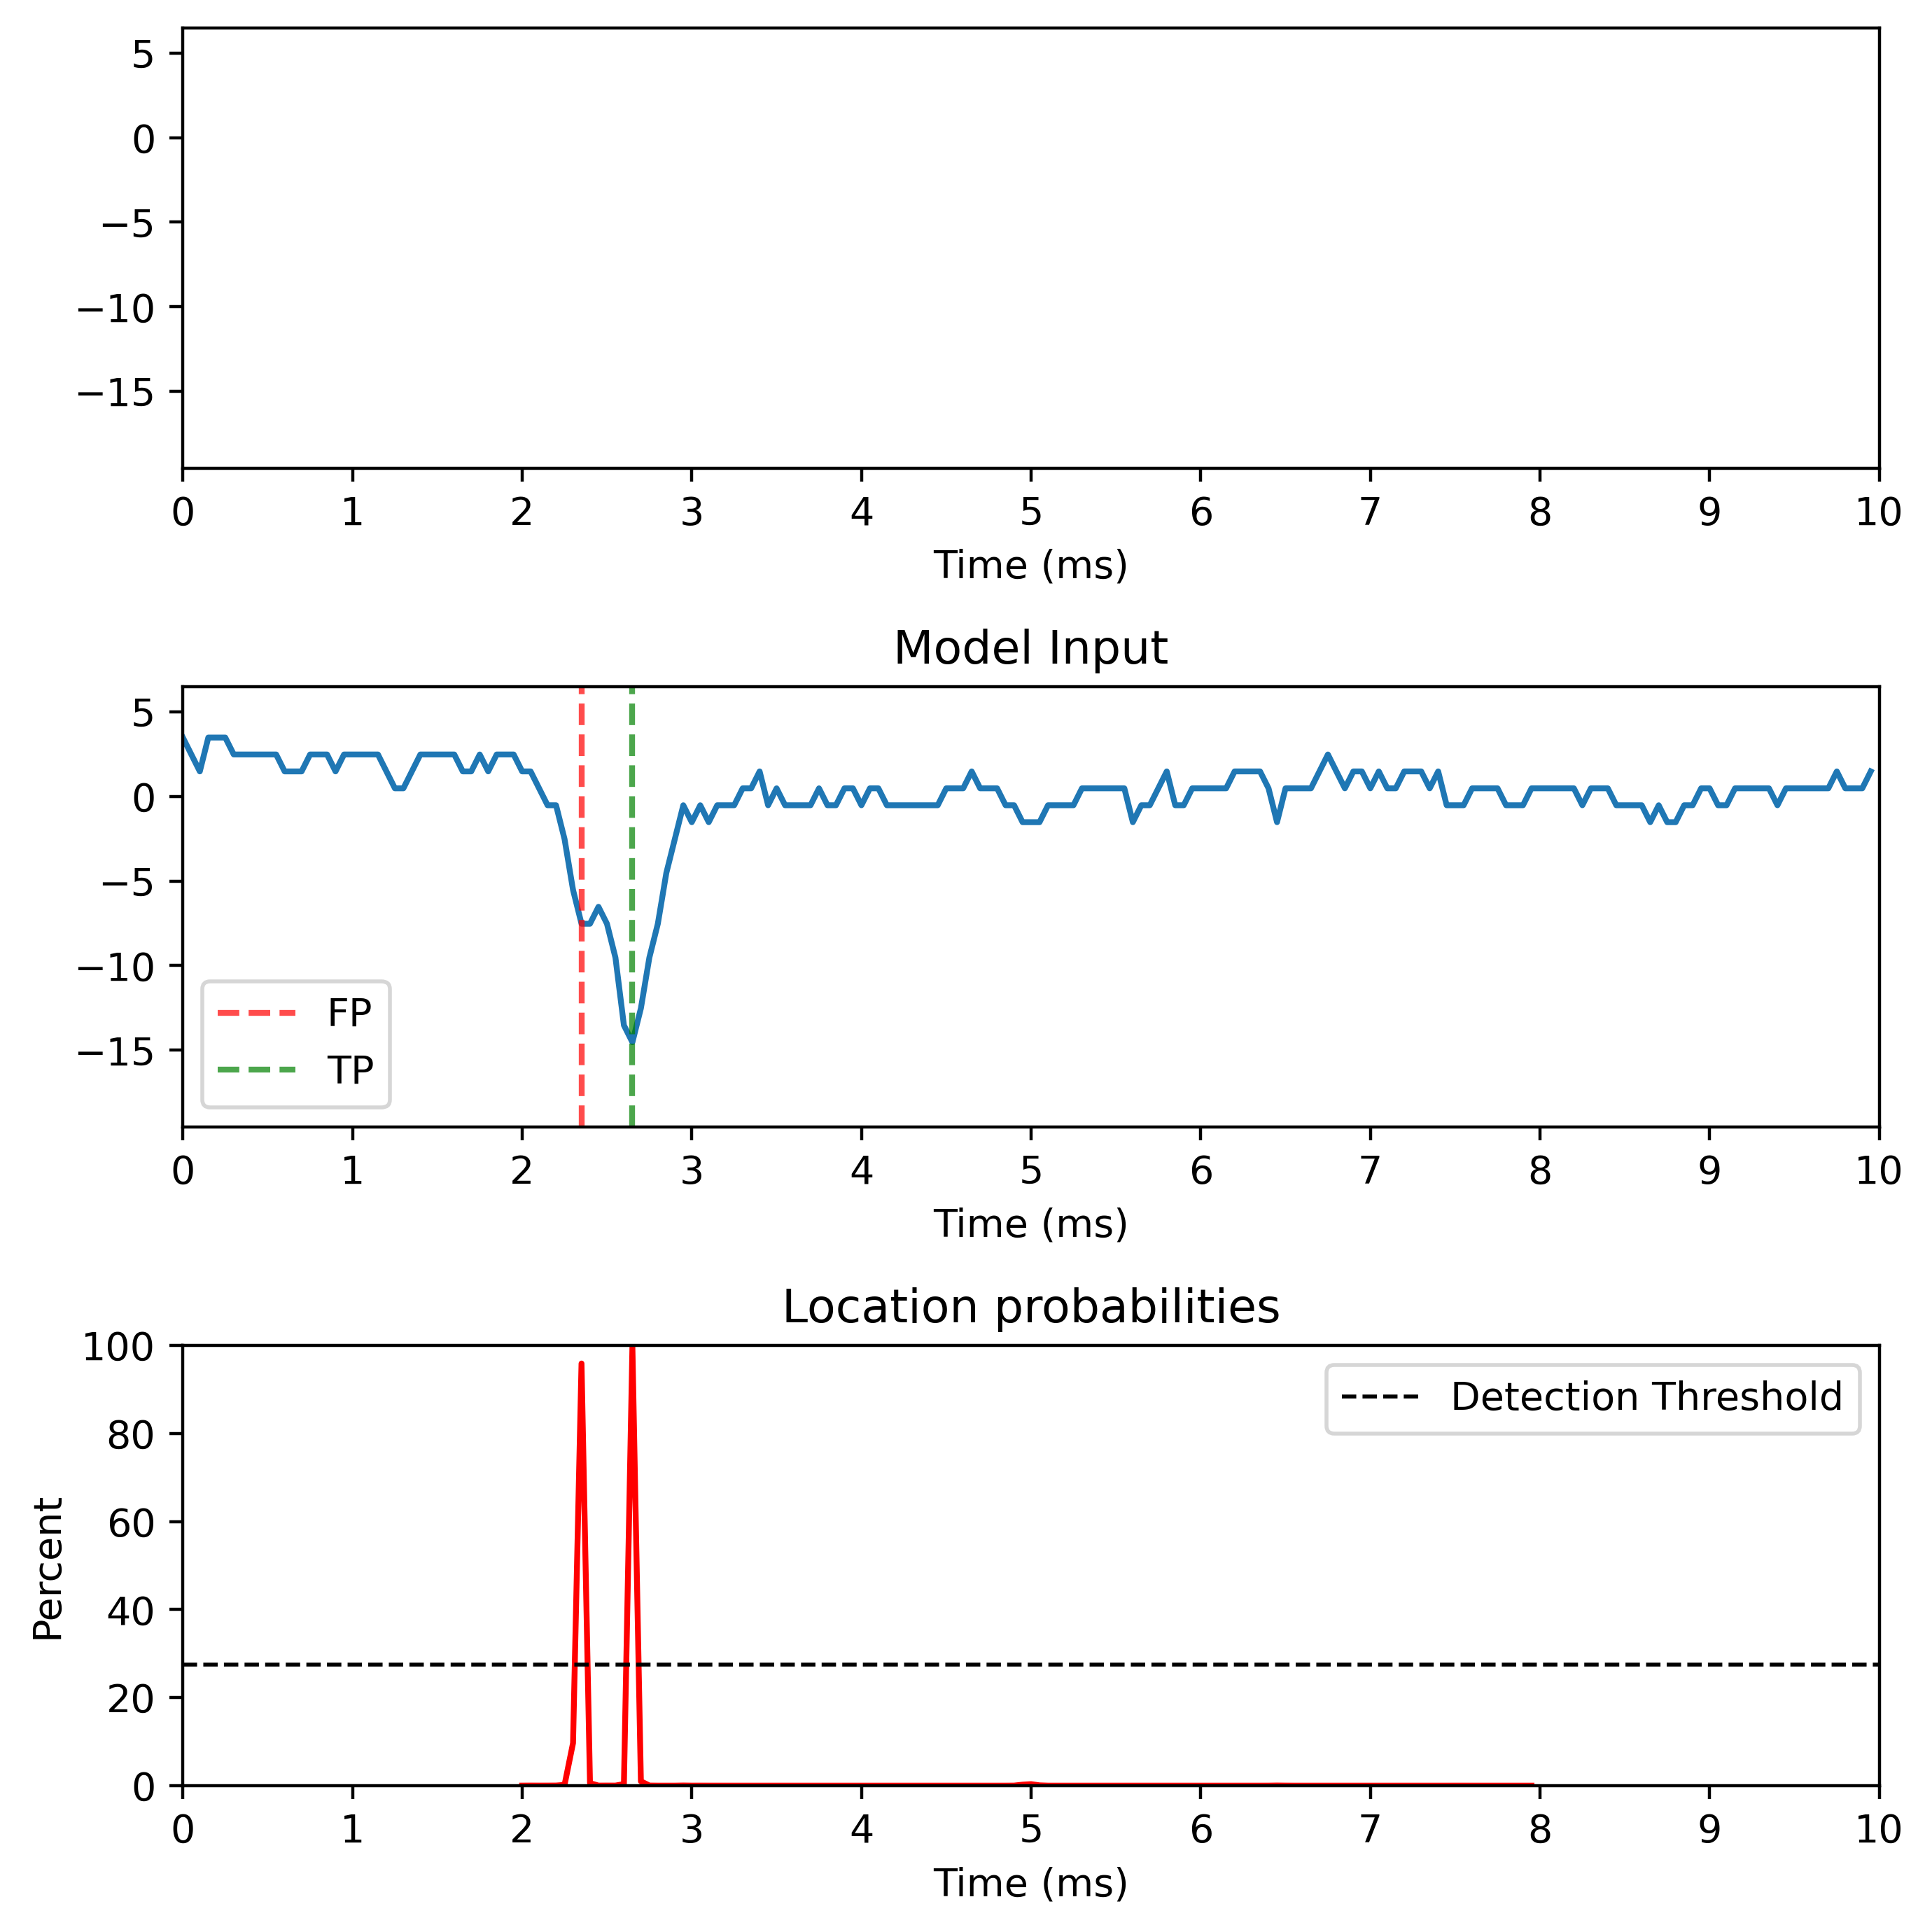

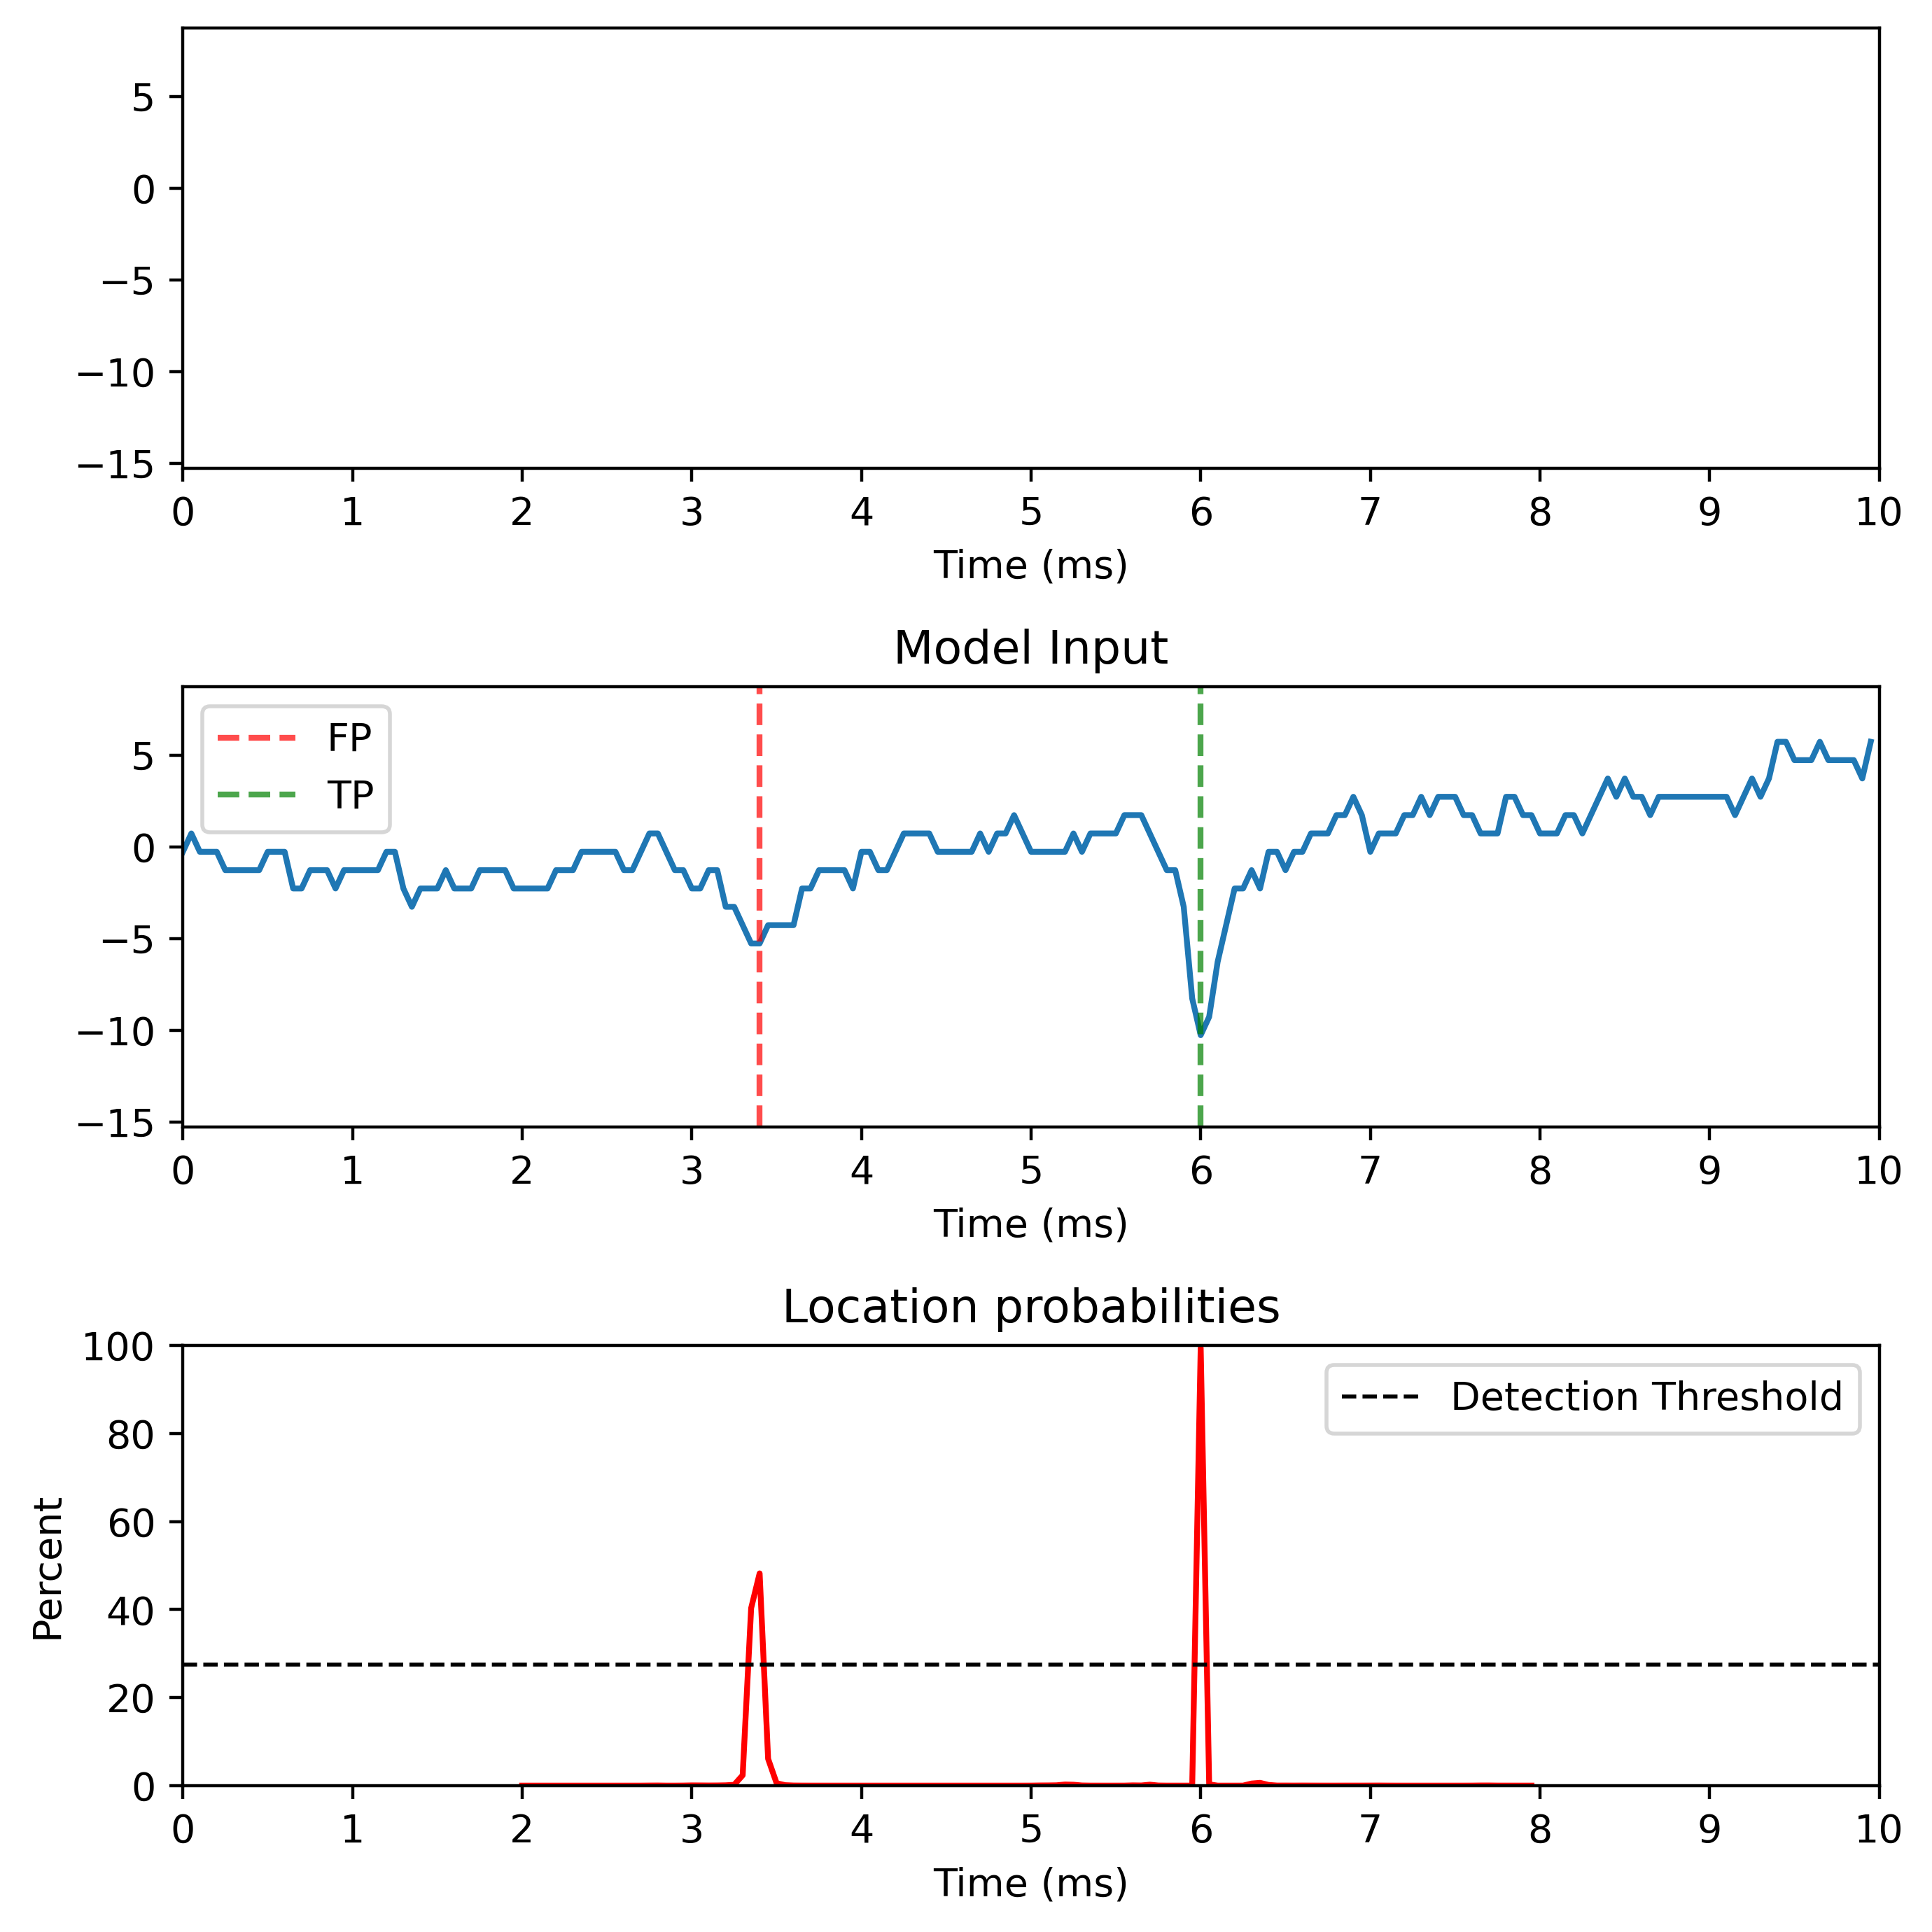

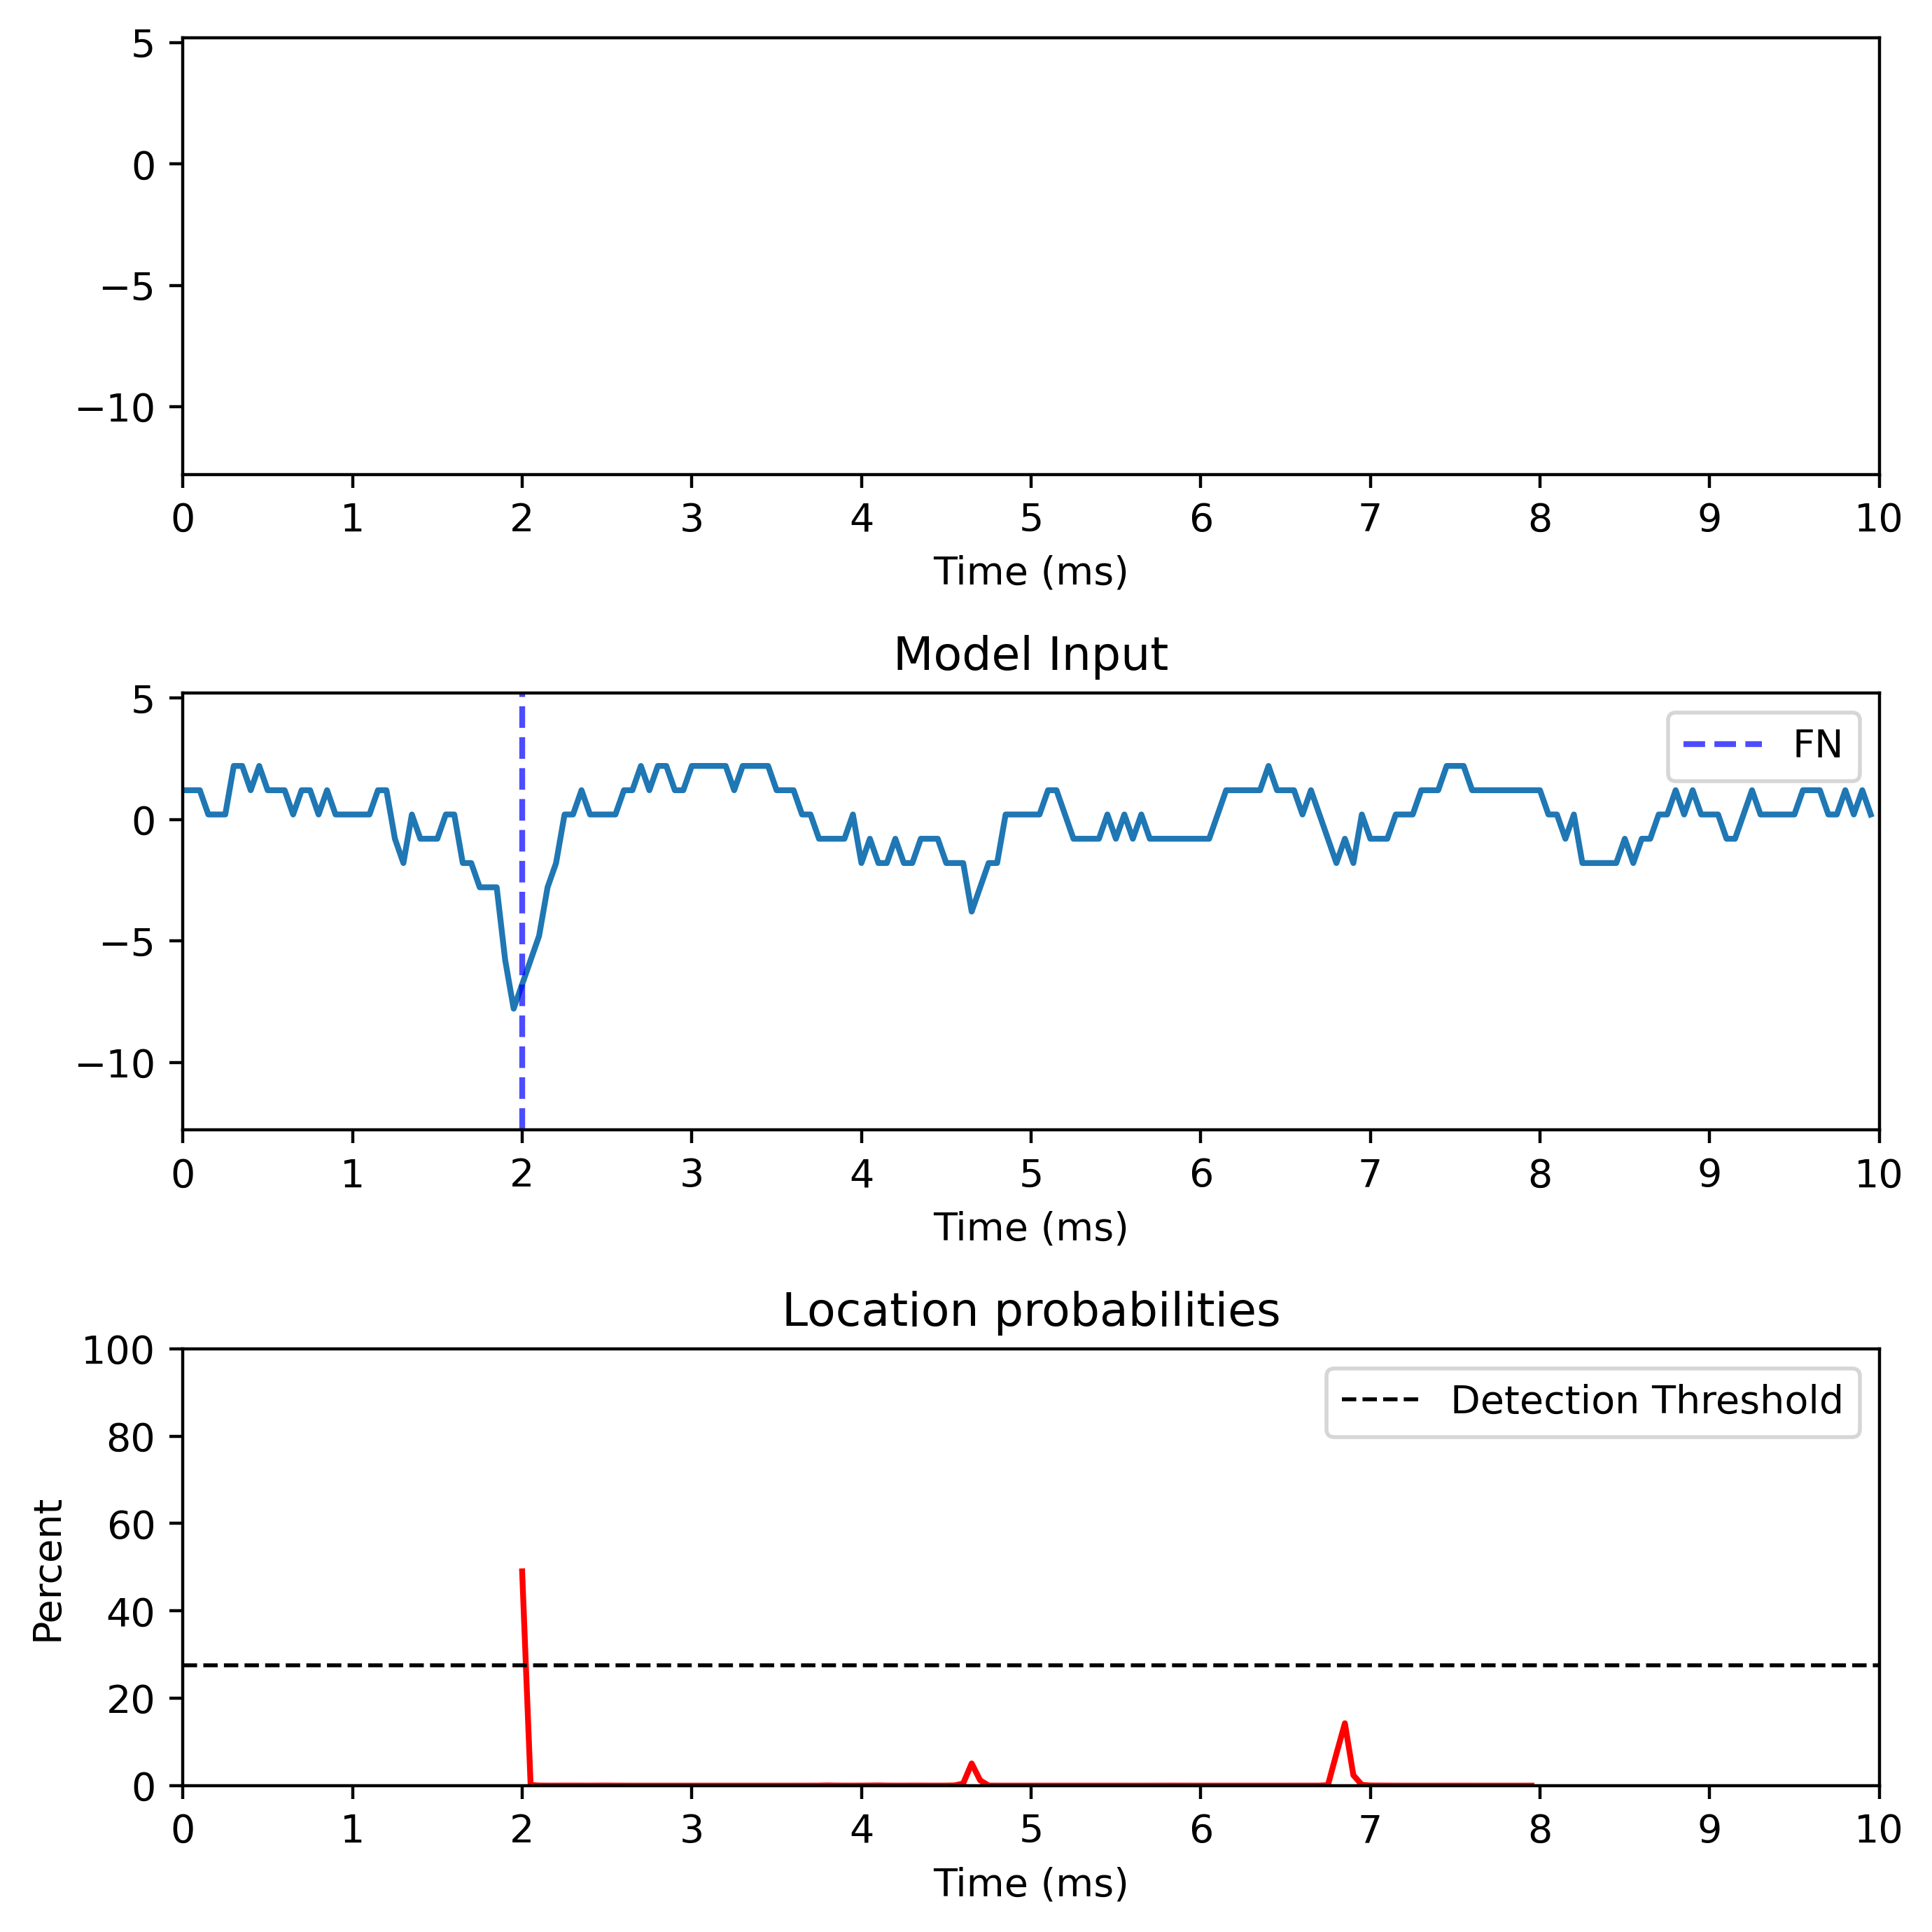

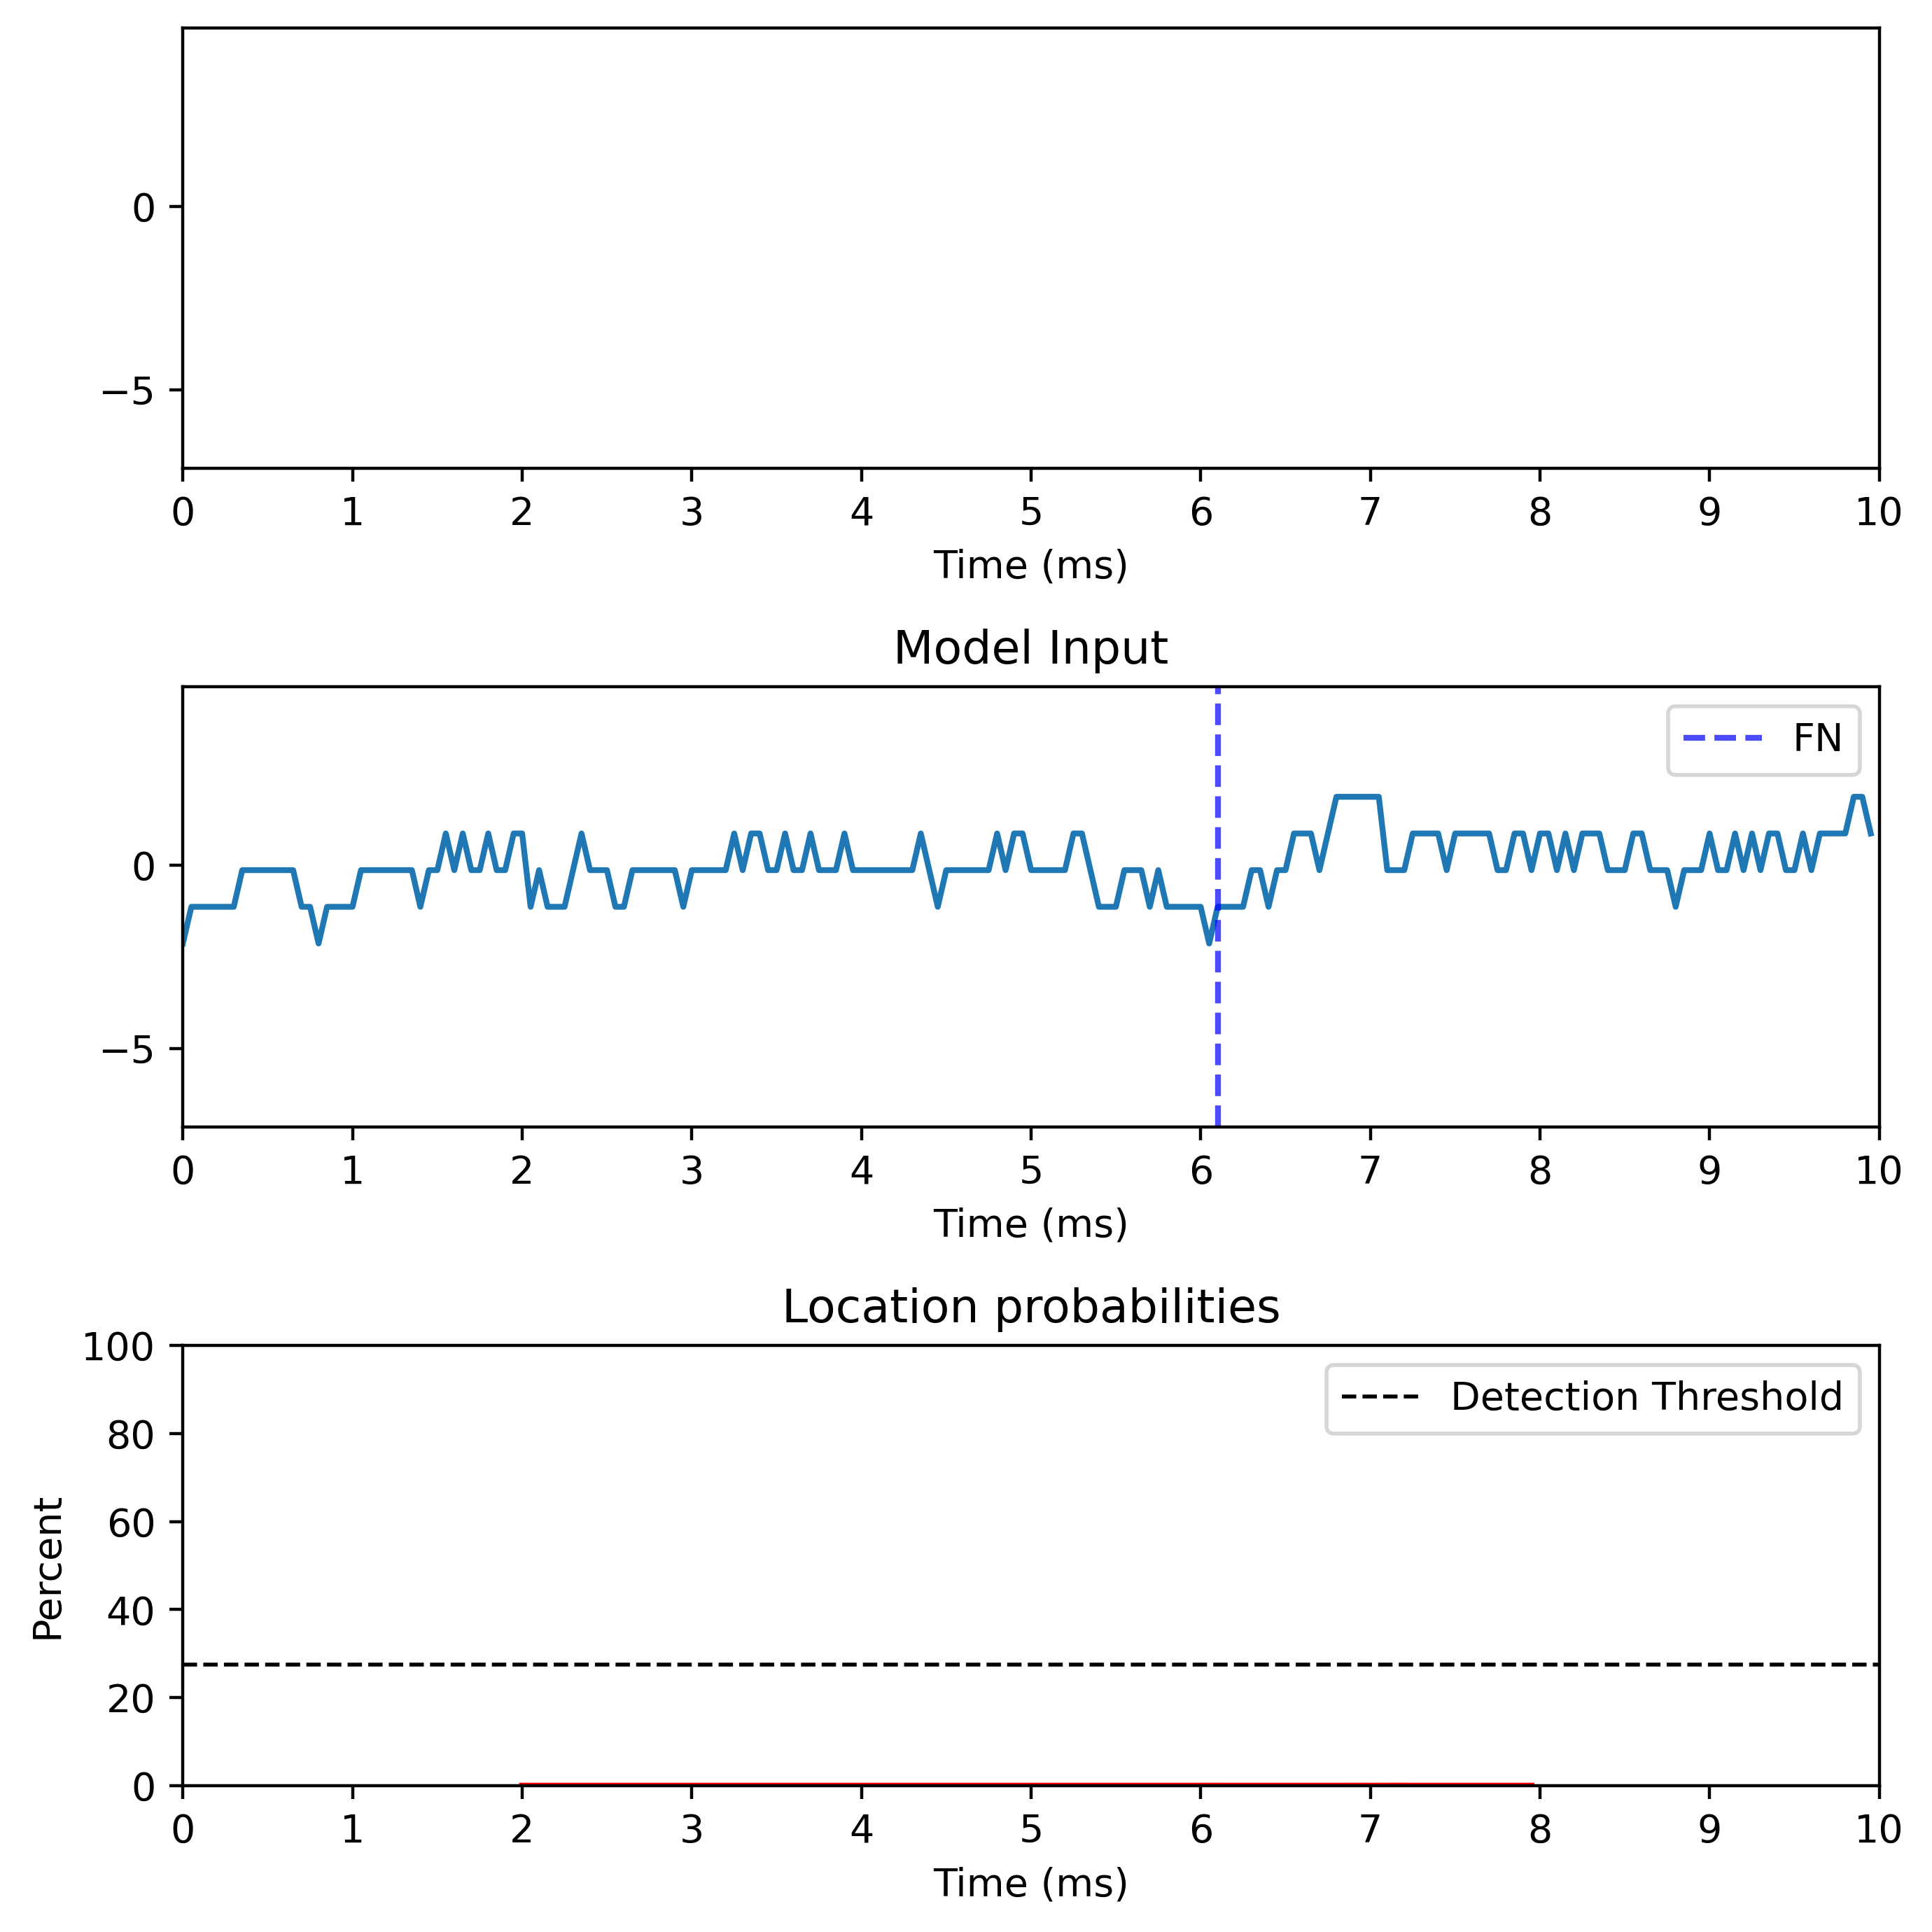

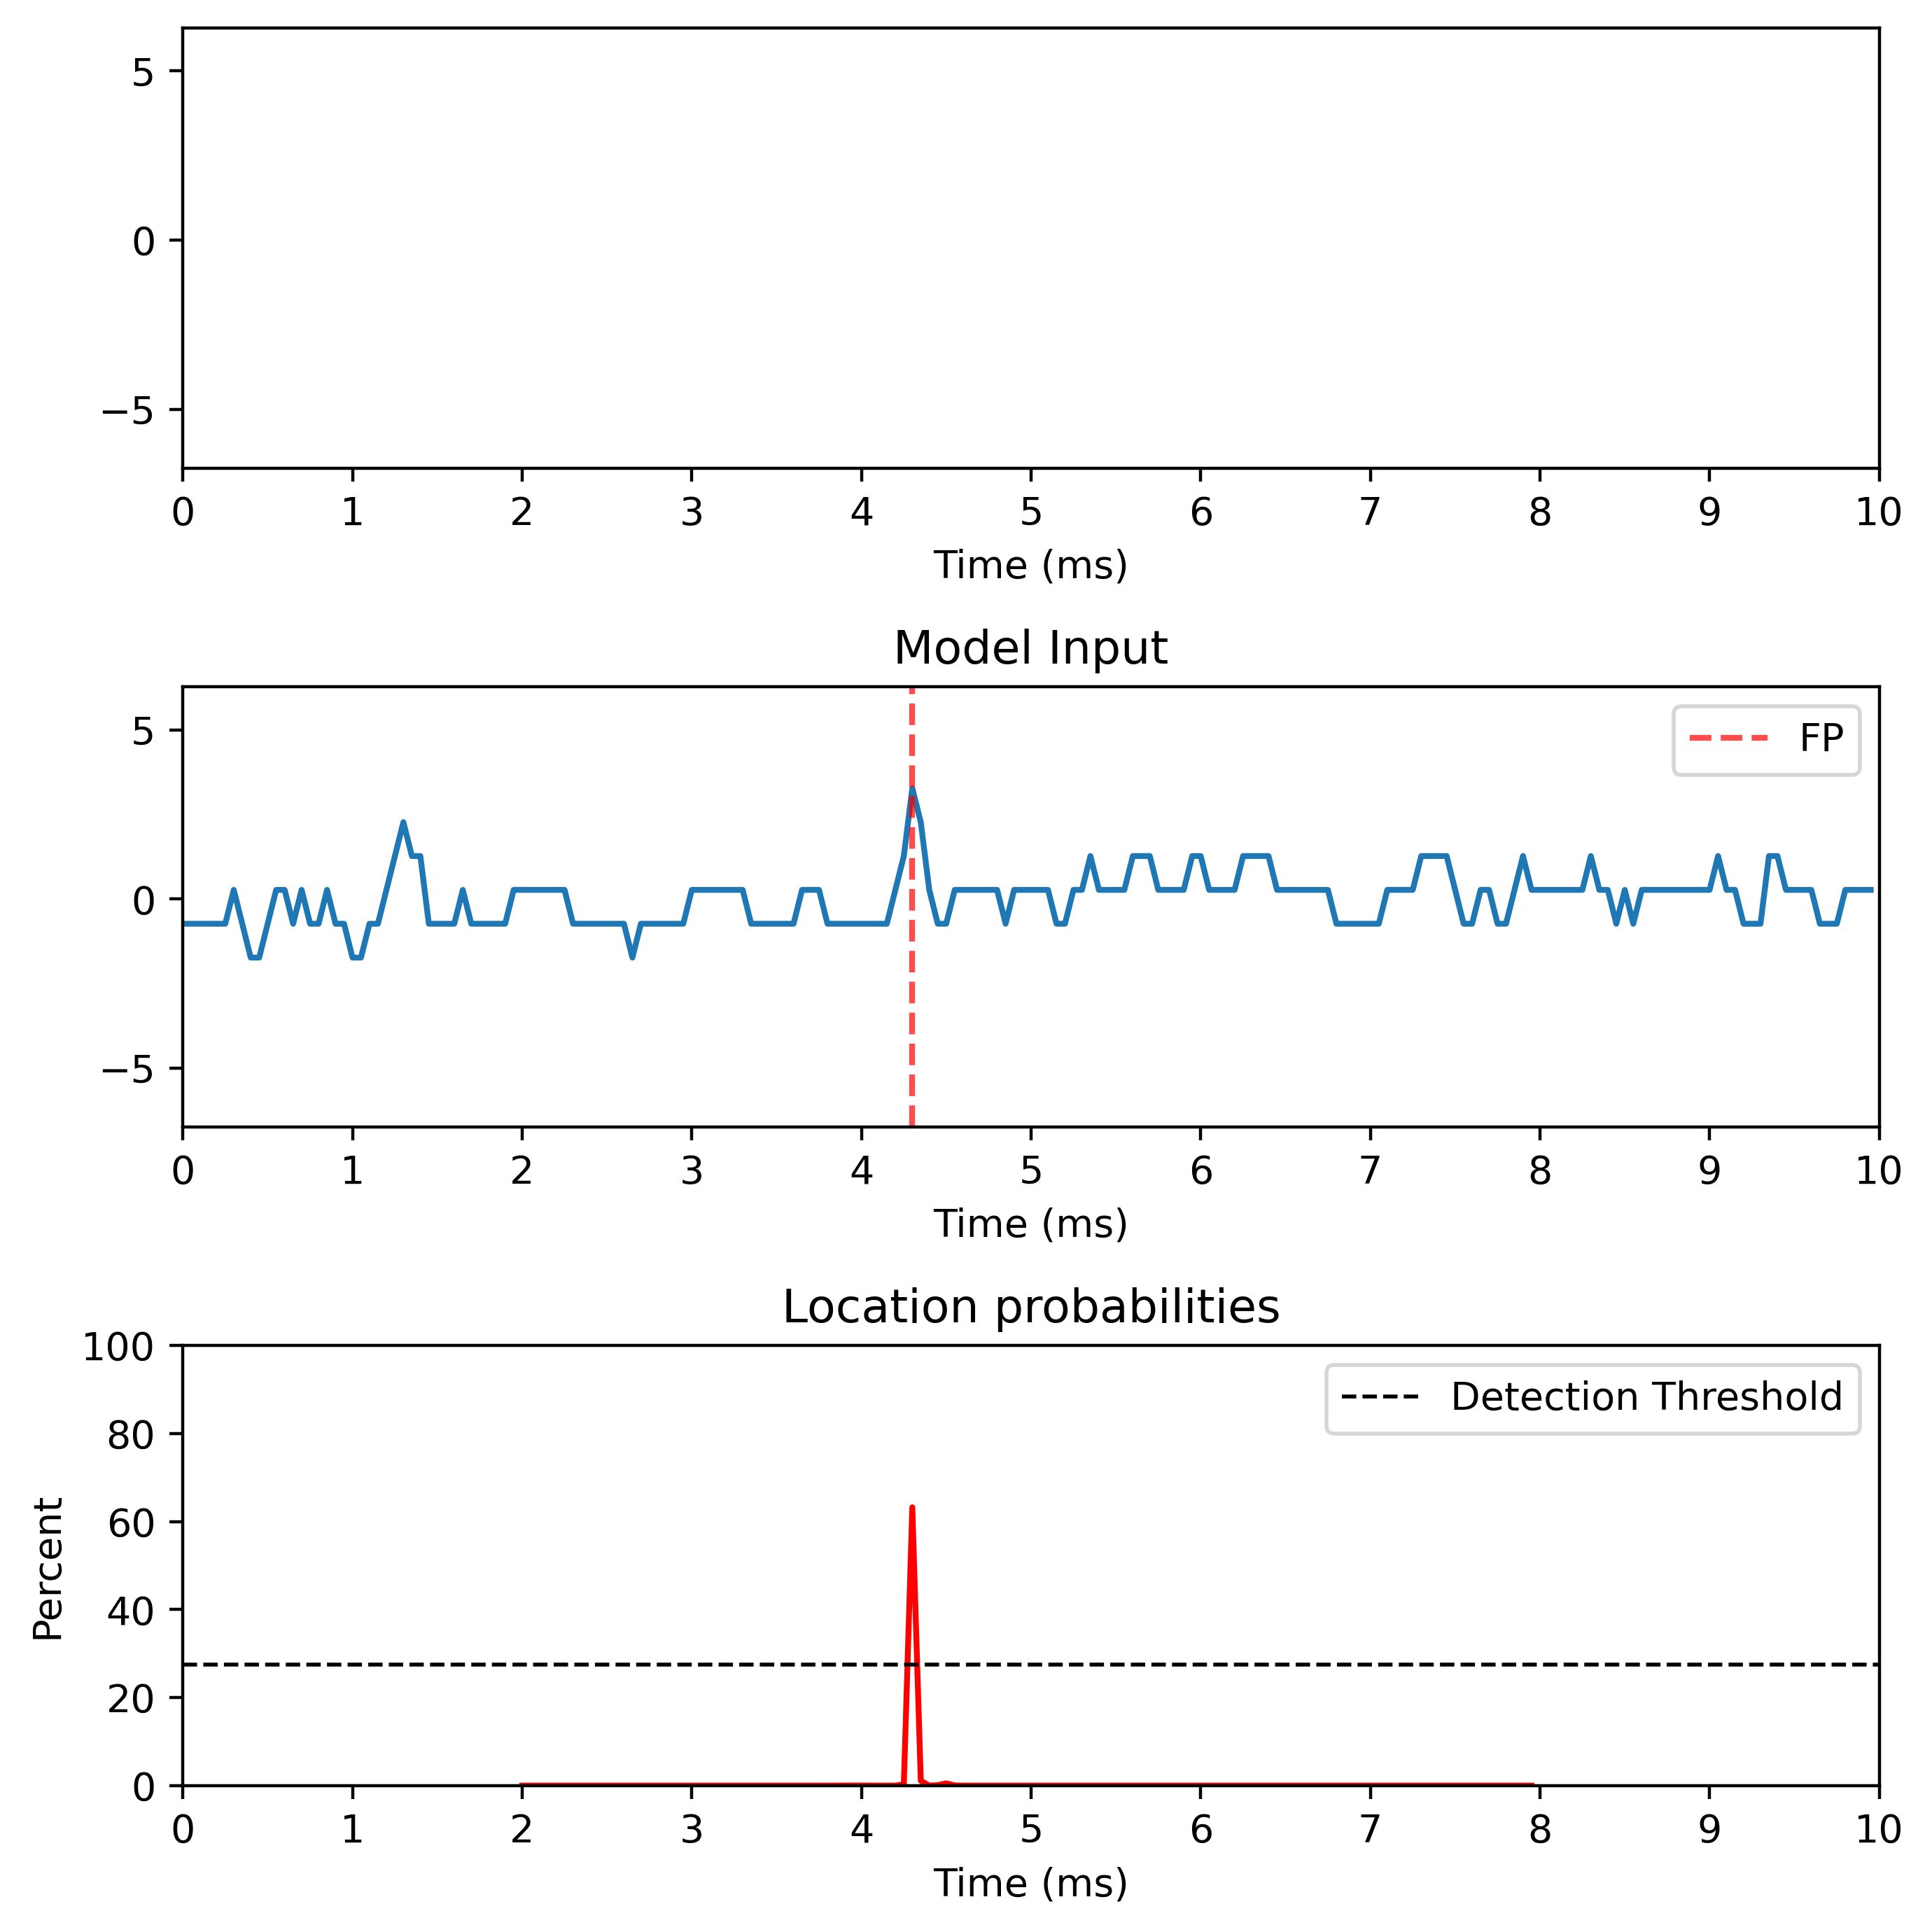

2954: Loss: 2.189 | WF Detected: 103.2% | Accuracy: 99.9% | Recall: 94.4% | Precision: 91.5% | F1 Score: 92.9% | Loc MAD: 0.58 frames = 0.0289 ms


In [145]:
# Plot failed samples
# Get model's performance
dataloader = DataLoader(rec_sampler, batch_size=2000)
# model.tune_loc_prob_thresh(dataloader)
perf = model.perf(dataloader, plot_preds=("failed",), max_plots=10)
_ = model.perf_report(REC, perf)